<a href="https://colab.research.google.com/github/CeloCruz/Hackathon/blob/main/Hackathon_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon Final JOBarcelona '23
## Contexto
El fútbol femenino ha experimentado un crecimiento exponencial en los últimos años, convirtiéndose en un deporte cada vez más popular y emocionante. Para la fase final presencial os presentamos un reto donde habrá que crear una web que permita visualizar las analíticas de los grandes equipos femeninos de Europa.

Autores:

* Ander Aquerreta
* Marcelo Cruz

In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt 
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
import seaborn as sns

# Varios
# ==============================================================================
from datetime import date
import json
import re


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Acceder a google drive
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
teams = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/teams_1.csv')
teams.head()

,Squad_id,Squad,#Pl,Age,Poss,MP,Min,Gls,Ast,PK,...,Carries_PrgDist,Carries_Dis,Receiving_Rec,2CrdY,Fls,Fld,Off,PKcon,OG,Recov
0,aa11fb42,Alavés,22,27.0,43.5,26,2340,30,18,1,...,13585,266,5803,1,276,262,56,2,4,1352
1,e9fecaf2,Alhama,24,26.5,39.2,26,2340,20,12,1,...,8122,222,3911,3,332,235,82,3,3,1547
2,94929c05,Athletic Club,23,24.6,48.5,26,2340,28,20,2,...,15920,263,7254,0,243,224,64,4,0,1694
3,b56c2667,Atlético Madrid,22,26.2,55.1,26,2340,46,30,3,...,24412,334,9880,0,247,273,79,4,1,1546
4,15f49df1,Barcelona,28,27.1,69.4,25,2250,100,69,3,...,26950,283,13976,0,217,207,104,1,0,1611


### ¿Hay valores faltantes en nuestro dataset?

In [4]:
teams.isnull().sum().sum()

0

Comprobamos que no existen valores faltantes facilmente detectables por pandas

In [5]:
teams[teams.isin(['-','--','na','.','nan','unknown','ukn','Unknown'])].count().sort_values(ascending=False)

Squad_id          0
Touches_DefPen    0
GCA               0
GCA_PassLive      0
GCA_PassDead      0
                 ..
PPA               0
SCA               0
SCA_PassLive      0
SCA_PassDead      0
Recov             0
Length: 62, dtype: int64

Vemos que tenemos un dataset sin valores faltantes para ninguna de las columnas

¿Tenemos registros duplicados?

In [6]:
teams.duplicated().sum()

0

¿Cuántas equipos hay en el dataset?

In [7]:
teams.Squad.nunique()

62

Tenemos un dataset bastante limpio en el que no existen campos con valores falatantes para ningun atributo de ninguno de los registros

## Análisis de contenido de datos

Facilitamos el nombre e id de los equipos para el equipo de backend

In [58]:
teams_csv = teams[['Squad_id','Squad']]
teams_csv.set_index('Squad_id', inplace=True)
teams_csv.to_csv('teams_clean.csv')

### Atributos de mayor interés
Seleccionamos aquellos atributos de mayor interés que nos den una vista global del rendimiento del fútbol femenino, así como estadísticas mas relevantes por equipo, que luego nos permitiran hacer diversos tipos de análisis comparandolos entre todos.



In [8]:
teams_df = teams[['Squad_id','Squad','#Pl','Age','Poss','MP','Gls','Ast','PK','PKatt','CrdY','CrdR','Sh','Fls','Fld','Off','PKcon','OG']]
teams_df.head()

,Squad_id,Squad,#Pl,Age,Poss,MP,Gls,Ast,PK,PKatt,CrdY,CrdR,Sh,Fls,Fld,Off,PKcon,OG
0,aa11fb42,Alavés,22,27.0,43.5,26,30,18,1,1,52,1,242,276,262,56,2,4
1,e9fecaf2,Alhama,24,26.5,39.2,26,20,12,1,1,55,4,276,332,235,82,3,3
2,94929c05,Athletic Club,23,24.6,48.5,26,28,20,2,3,34,1,284,243,224,64,4,0
3,b56c2667,Atlético Madrid,22,26.2,55.1,26,46,30,3,4,36,0,343,247,273,79,4,1
4,15f49df1,Barcelona,28,27.1,69.4,25,100,69,3,5,24,0,614,217,207,104,1,0


### Inspeccionamos el dataset de los partidos

In [9]:
matches = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/matches_1.csv')
matches.head()

,Match_id,Date,Time,Wk,Home_id,Away_id,ScoreHome,ScoreAway,League_name,Round
0,4df3a732,2022-09-17,12:00,2,15f49df1,4c088abe,2,0,Liga-F,NaN
1,87c755cd,2022-09-17,12:00,2,aa11fb42,89818574,1,2,Liga-F,NaN
2,abfde9d9,2022-09-17,16:00,2,c21f25d3,7a7bef84,2,0,Liga-F,NaN
3,d0329f46,2022-09-17,16:00,2,54582b93,f96ff499,2,0,Liga-F,NaN
4,f4452586,2022-09-17,18:00,2,215d9026,b56c2667,1,3,Liga-F,NaN


¿Qué tamaño tiene el set de datos de matches?

In [10]:
matches.shape

(643, 10)

Añadimos una columna de goles totales

In [11]:
matches["Goles Tot"] = matches["ScoreHome"] + matches["ScoreAway"]

<Axes: ylabel='League_name'>

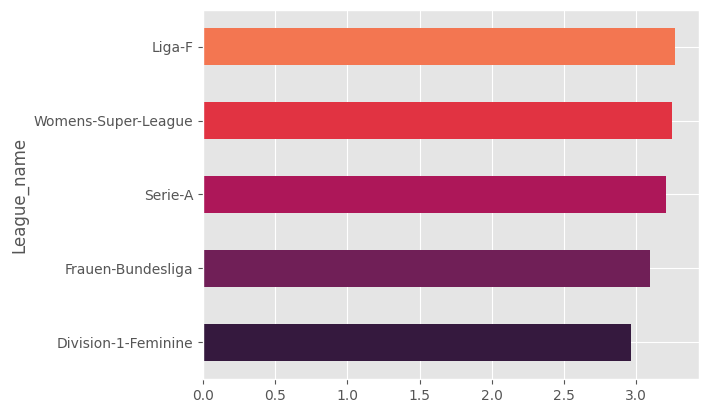

In [18]:
media_por_liga = matches.groupby(["League_name"]).mean()["Goles Tot"]
#media_por_liga["Liga"] = media_por_liga.index
media_por_liga.sort_values().plot(kind='barh', color=sns.color_palette('rocket'))

¿Exietn valores nulos en el dataset de partidos?

In [19]:
print('Numero de nulos totales del dataset: {}'.format(matches.isnull().sum().sum()))
matches.isnull().sum()

Numero de nulos totales del dataset: 533


Match_id         0
Date             0
Time             0
Wk               0
Home_id          0
Away_id          0
ScoreHome        0
ScoreAway        0
League_name      0
Round          533
Goles Tot        0
dtype: int64

¿Cuántas semanas hay en el dataset?

In [21]:
np.unique(matches["Wk"])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

**Relacionamos ambos datasets** para obtener el dato de a que liga pertenece cada equipo, para eso relacionamos el `squad_id` con el id de los equipos localcales (`home_id`) haciendo un merge y obteniendo así la liga a la que pertenece cada equipo.

In [24]:
matches_clean = matches.loc[:, ["Home_id", "League_name"]].drop_duplicates()
matches_clean.columns = ["Squad_id", "League_name"]
teams_merged = teams_df.merge(matches_clean, on='Squad_id')
teams_merged.set_index('Squad_id', inplace=True)
teams_merged.columns = teams_merged.columns.str.lower()
teams_merged.head()

,squad,#pl,age,poss,mp,gls,ast,pk,pkatt,crdy,crdr,sh,fls,fld,off,pkcon,og,league_name
Squad_id,,,,,,,,,,,,,,,,,,
aa11fb42,Alavés,22,27.0,43.5,26,30,18,1,1,52,1,242,276,262,56,2,4,Liga-F
e9fecaf2,Alhama,24,26.5,39.2,26,20,12,1,1,55,4,276,332,235,82,3,3,Liga-F
94929c05,Athletic Club,23,24.6,48.5,26,28,20,2,3,34,1,284,243,224,64,4,0,Liga-F
b56c2667,Atlético Madrid,22,26.2,55.1,26,46,30,3,4,36,0,343,247,273,79,4,1,Liga-F
15f49df1,Barcelona,28,27.1,69.4,25,100,69,3,5,24,0,614,217,207,104,1,0,Liga-F


Calculamos cuál es el promedio de goles, asistencias y posesión por equipo dependiendo de la liga.

In [25]:
groupby_league = teams_merged.groupby('league_name')[['gls','ast','poss']].mean()
groupby_league = groupby_league.applymap('{:.2f}'.format)
groupby_league

,gls,ast,poss
league_name,,,
Division-1-Feminine,27.42,19.67,49.99
Frauen-Bundesliga,27.08,18.92,50.06
Liga-F,40.88,27.88,50.04
Serie-A,34.50,22.00,50.00
Womens-Super-League,27.17,19.25,50.00


In [27]:
# Obtenemos un dataset con las variables de nuestro interés
attack = teams_merged[['squad','gls','ast','poss','league_name']]
attack.set_index('squad', inplace=True)

# Introducimos el promedio de goles, asistencias y posesión de cada liga 
team_attstats = attack.merge(groupby_league, right_on='league_name', left_on='league_name', how='left')

# Quitamos y transformamos las columnas e índices
team_attstats.index = attack.index
team_attstats.drop('league_name', axis=1, inplace=True)
team_attstats[['gls_y','ast_y','poss_y']] = team_attstats[['gls_y','ast_y','poss_y']].astype(float)
team_attstats.head()

,gls_x,ast_x,poss_x,gls_y,ast_y,poss_y
squad,,,,,,
Alavés,30,18,43.5,40.88,27.88,50.04
Alhama,20,12,39.2,40.88,27.88,50.04
Athletic Club,28,20,48.5,40.88,27.88,50.04
Atlético Madrid,46,30,55.1,40.88,27.88,50.04
Barcelona,100,69,69.4,40.88,27.88,50.04


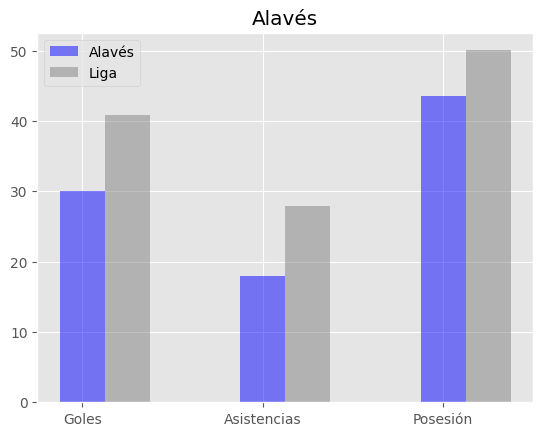

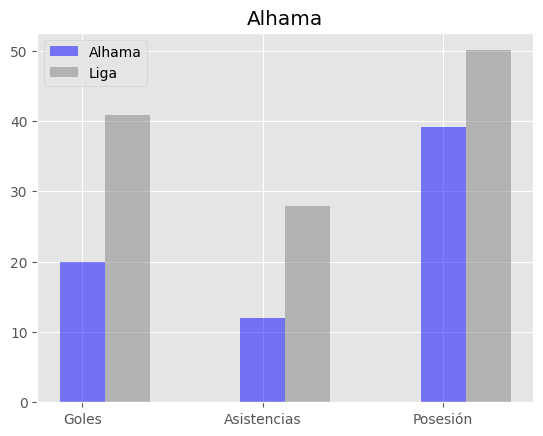

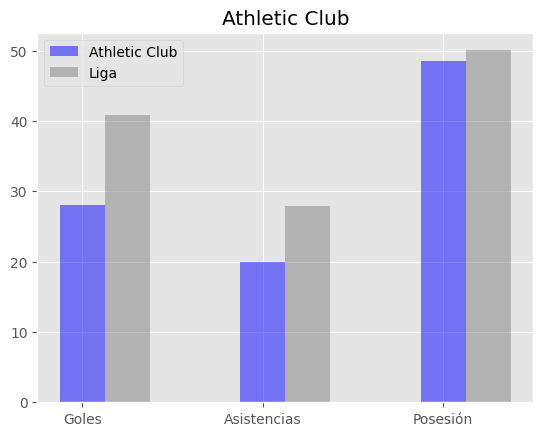

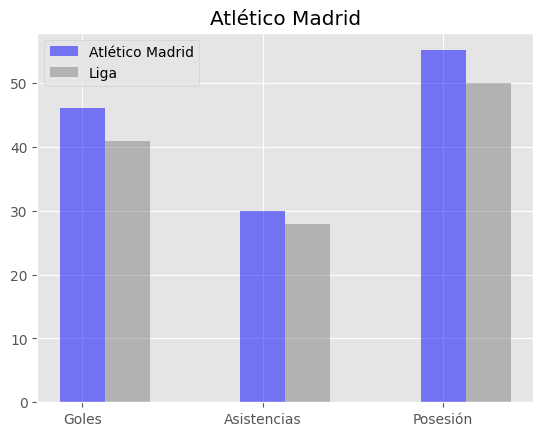

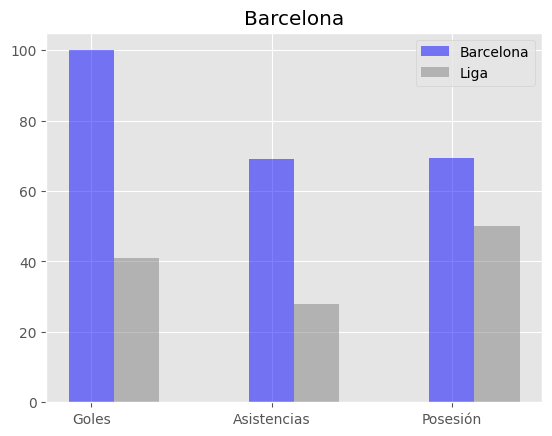

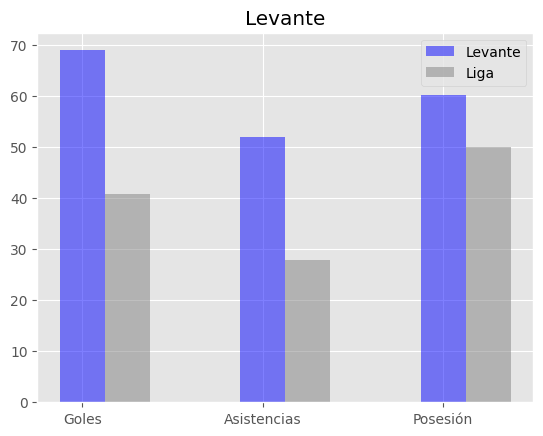

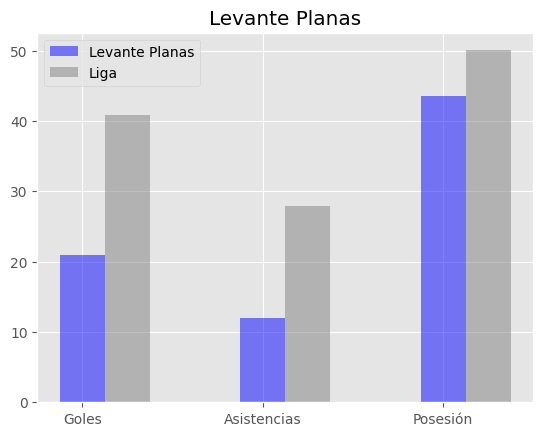

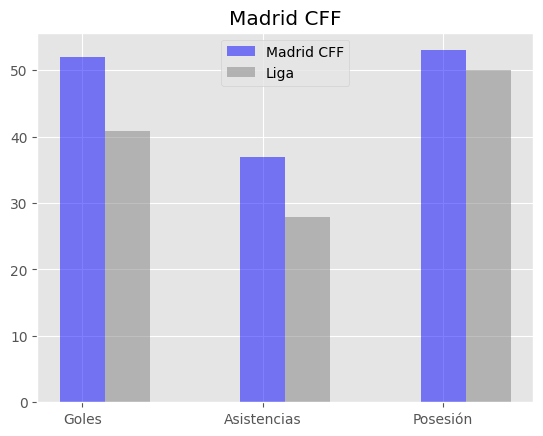

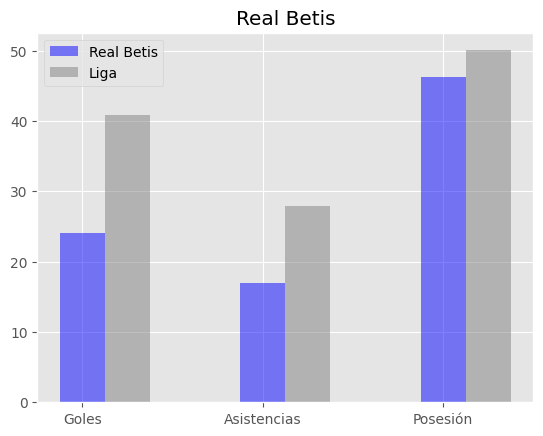

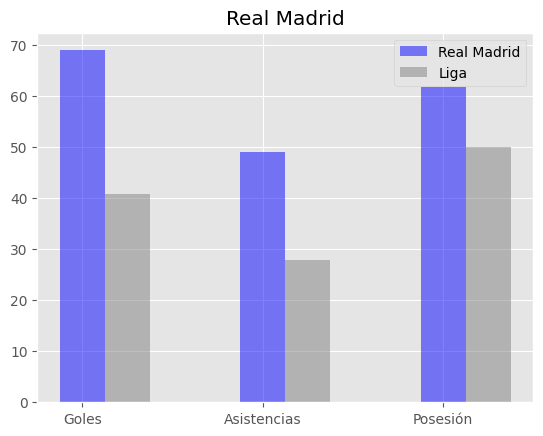

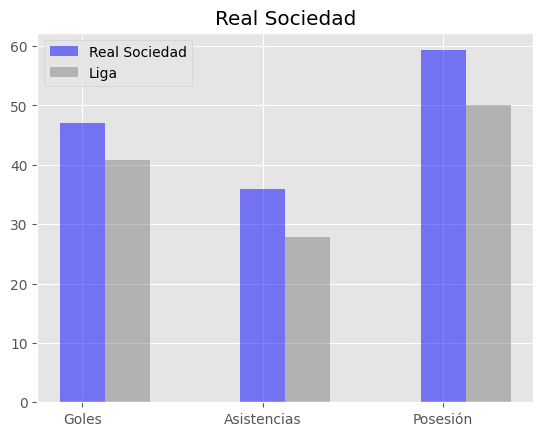

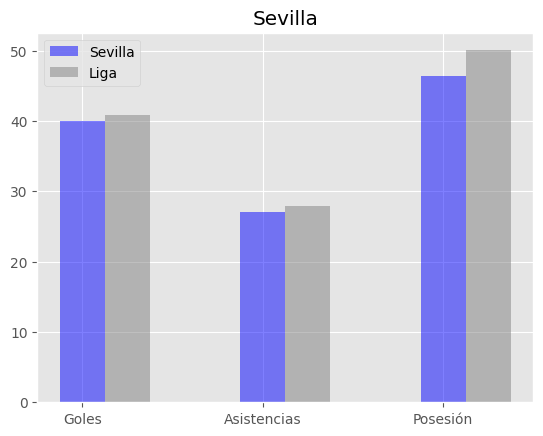

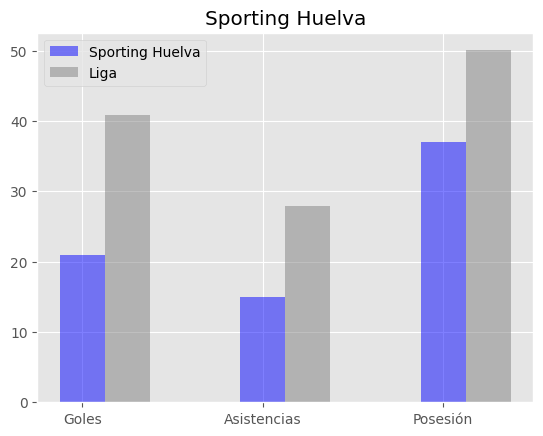

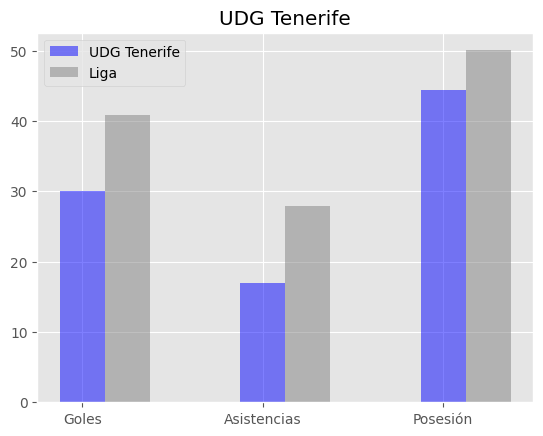

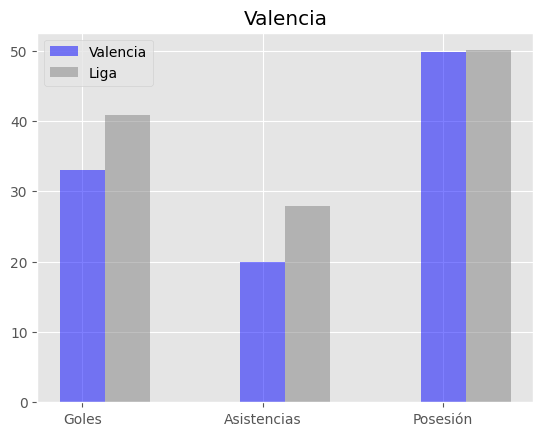

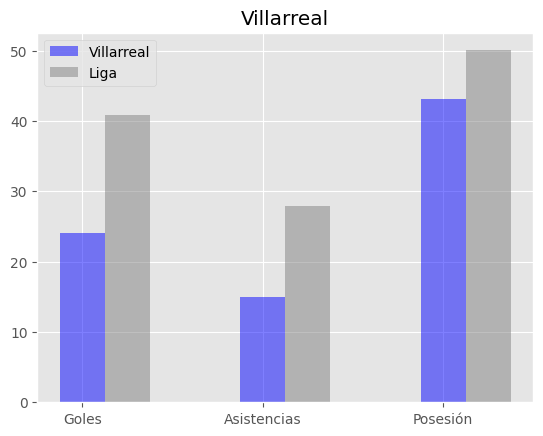

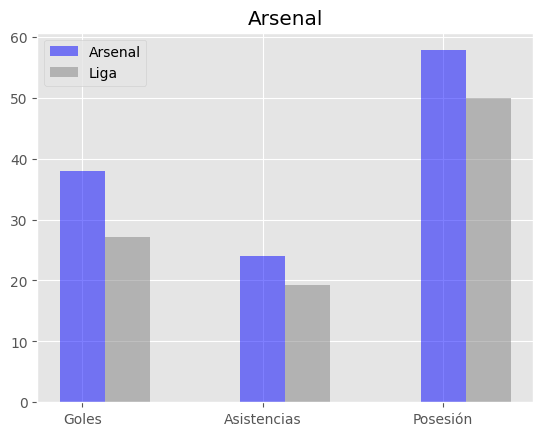

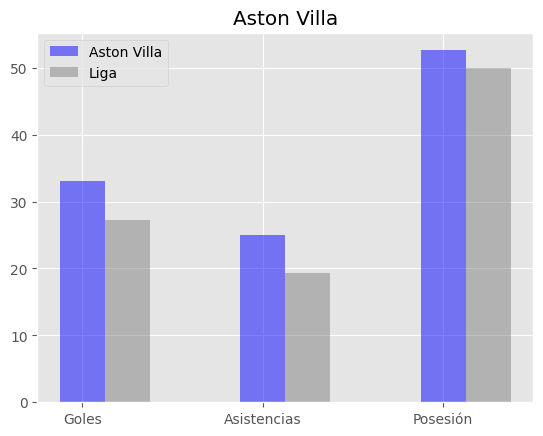

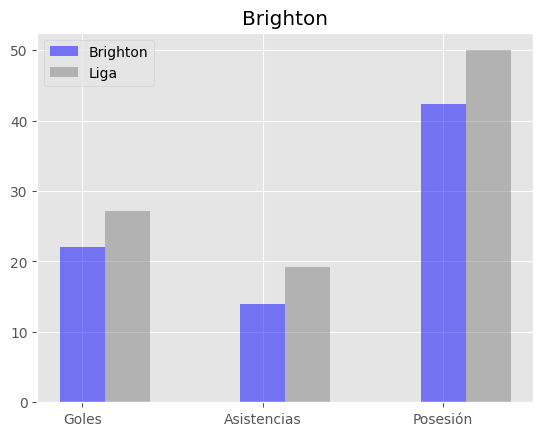

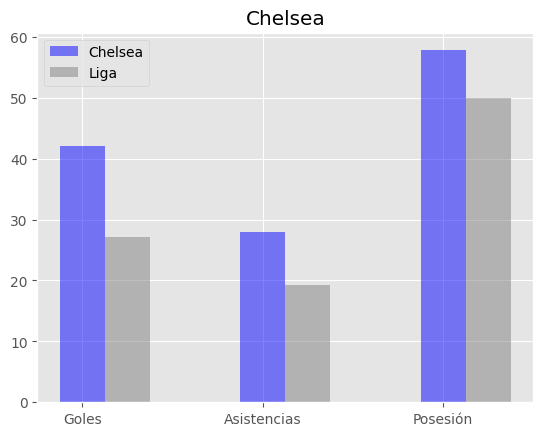

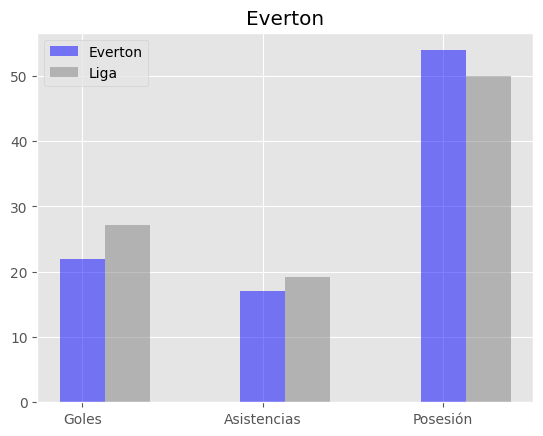

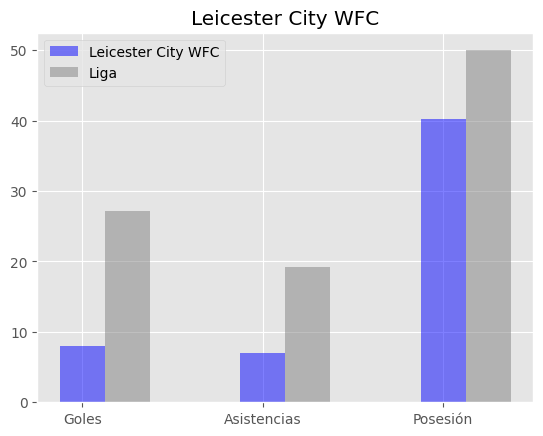

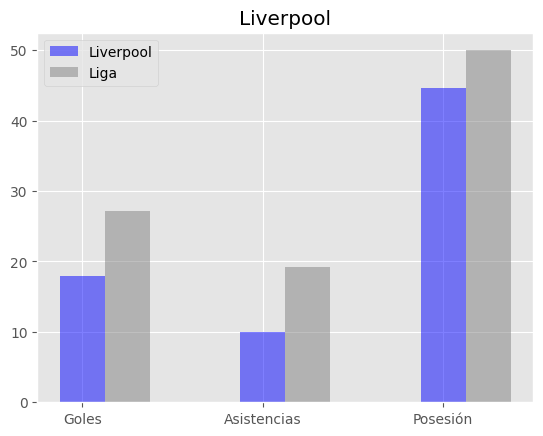

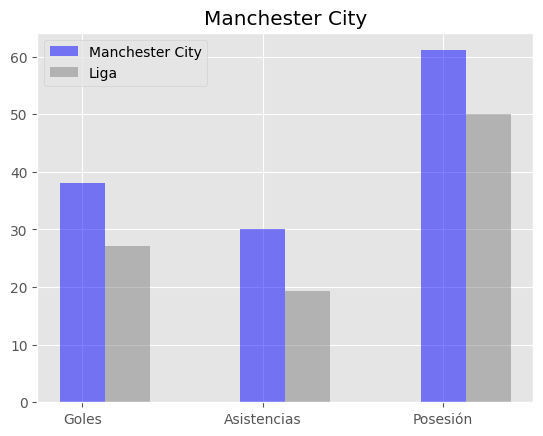

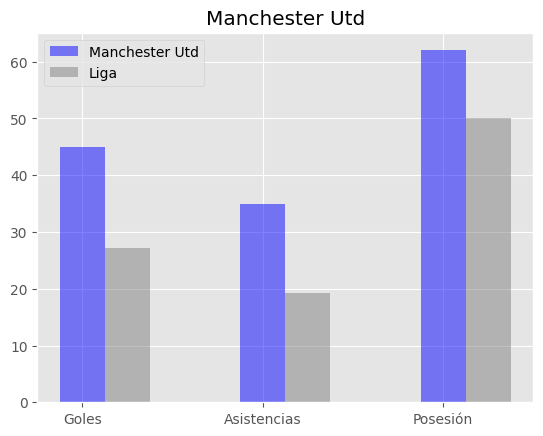

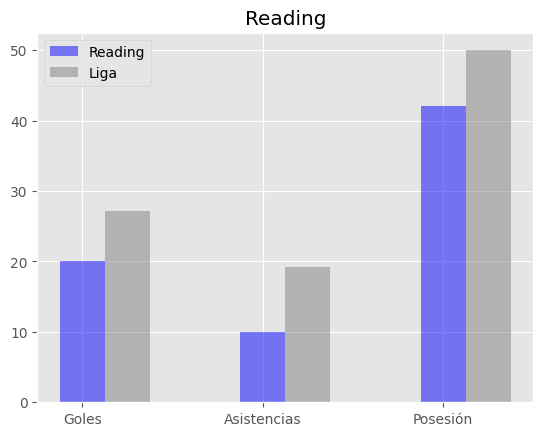

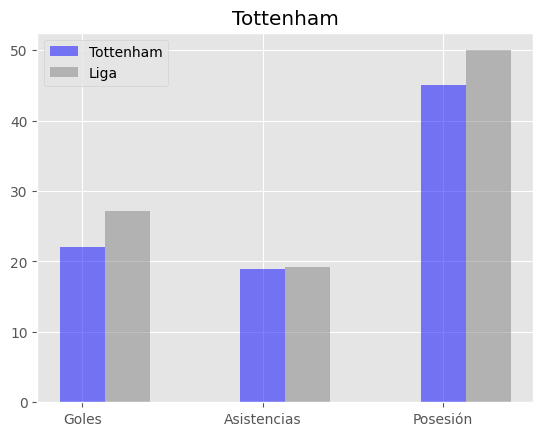

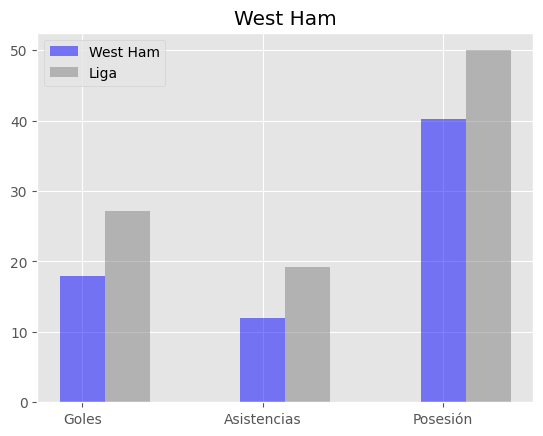

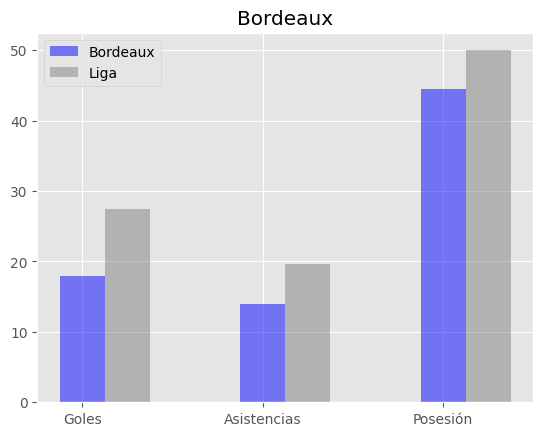

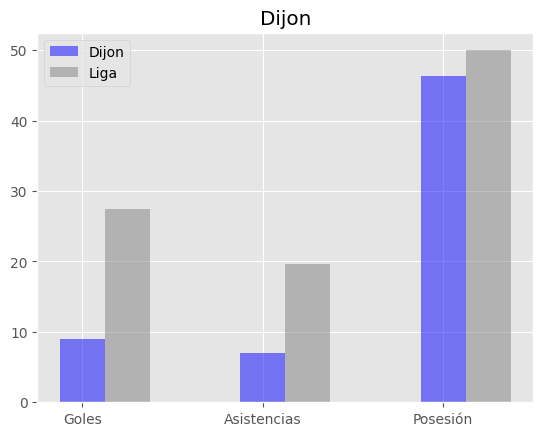

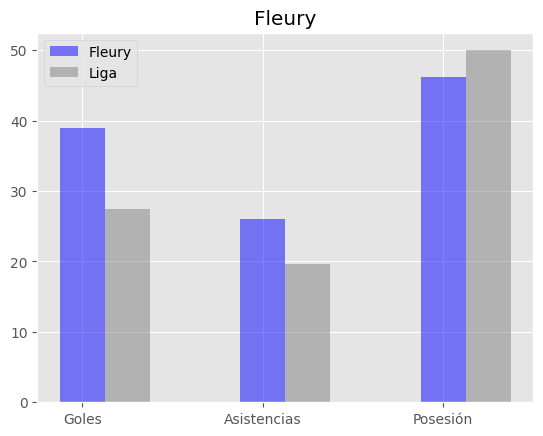

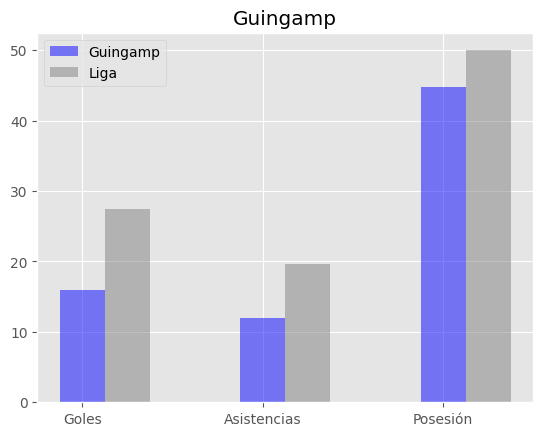

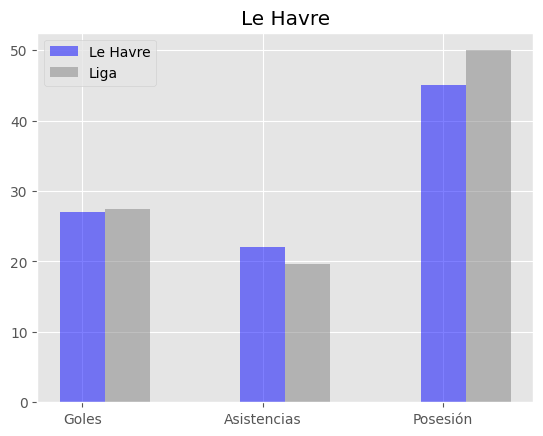

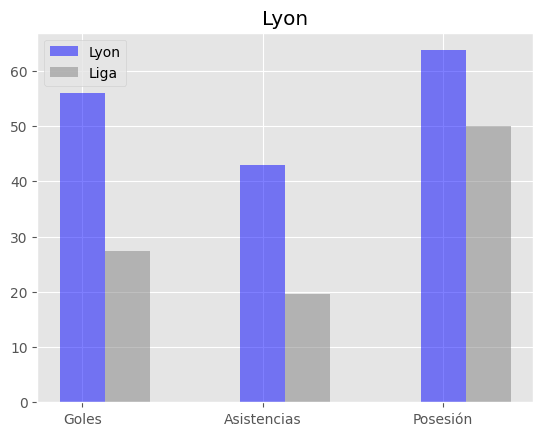

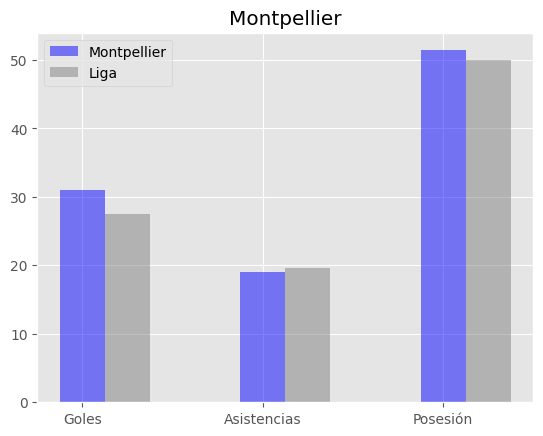

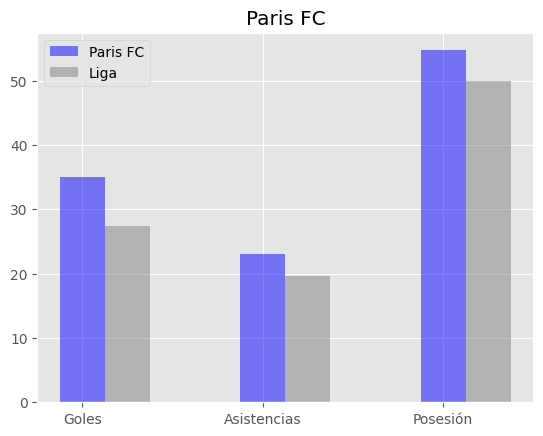

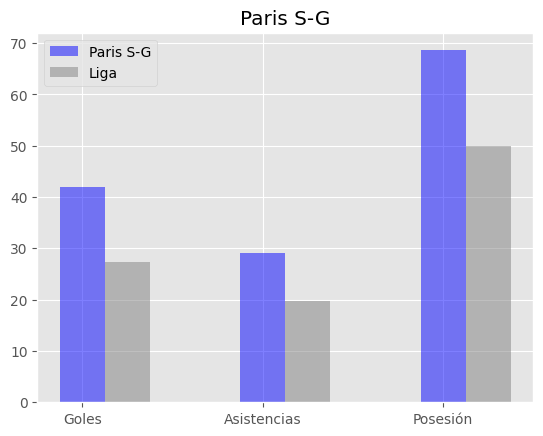

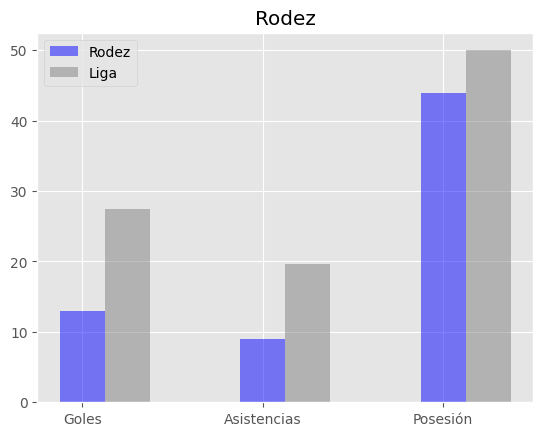

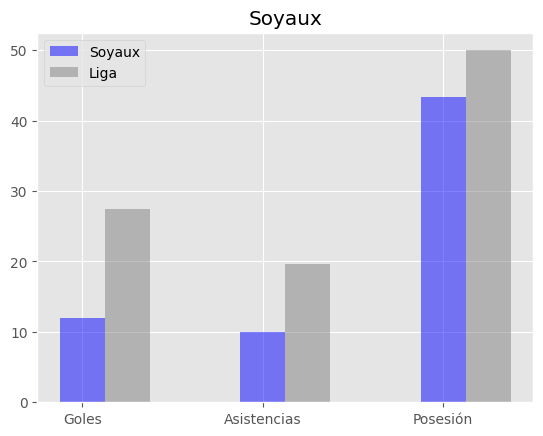

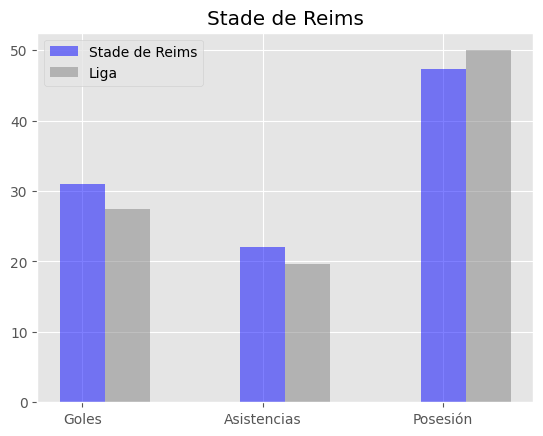

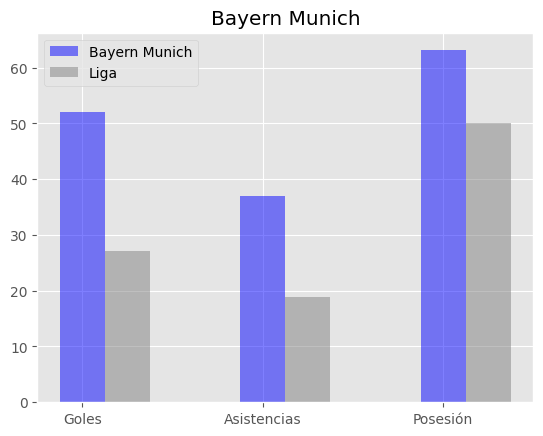

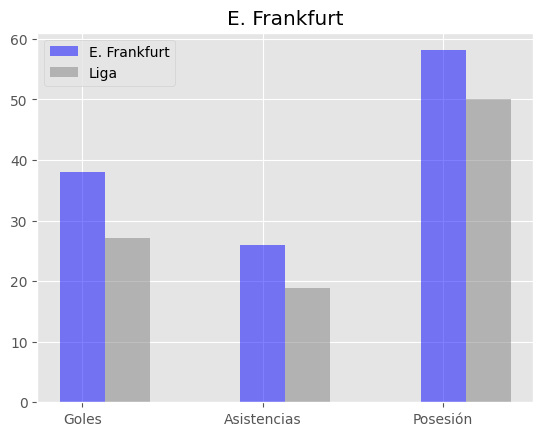

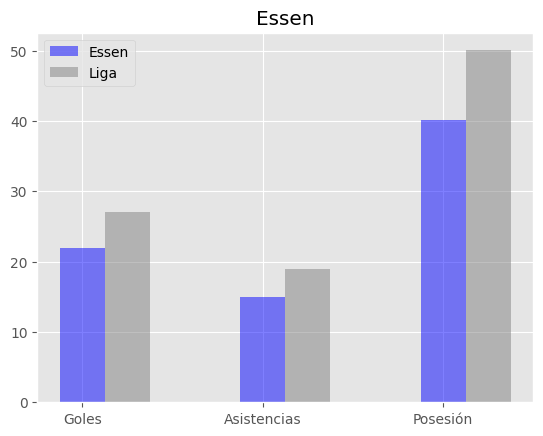

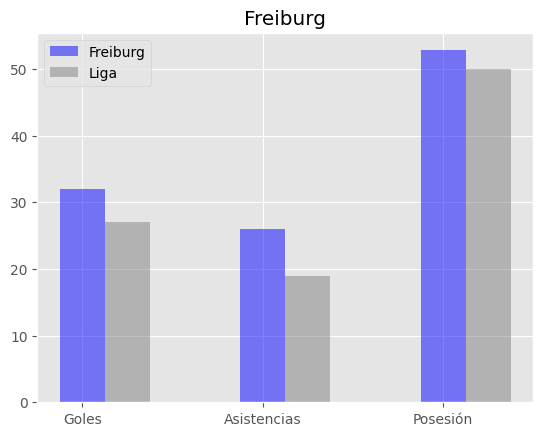

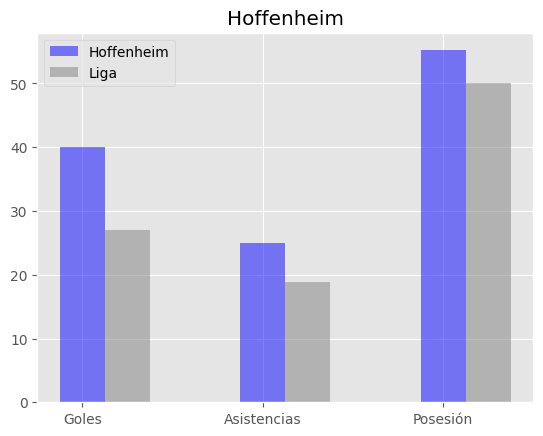

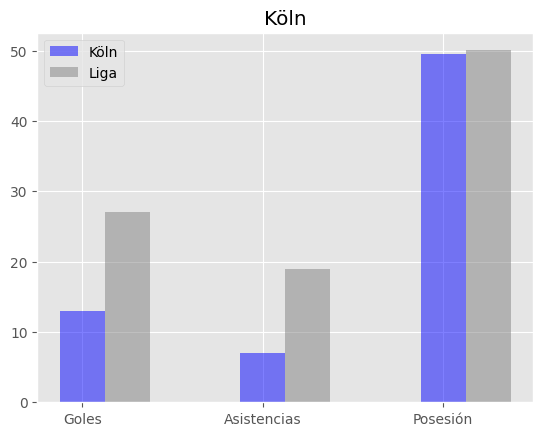

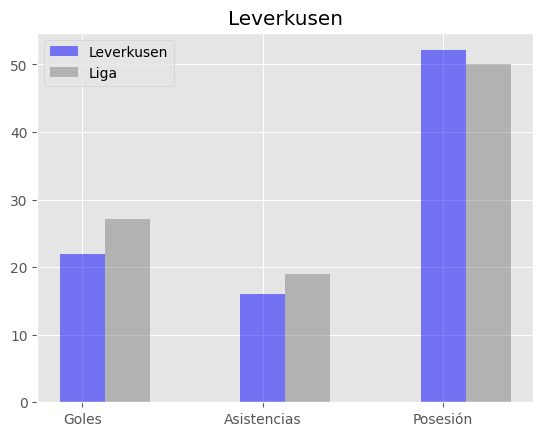

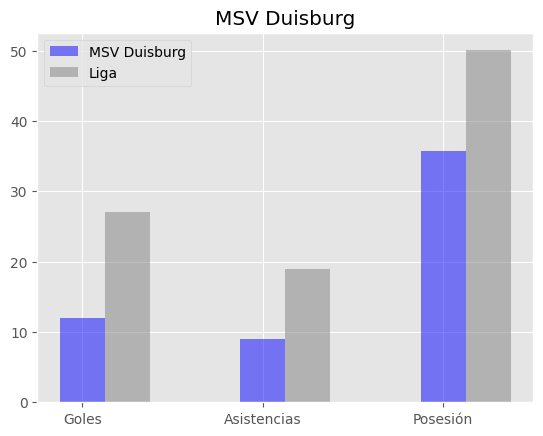

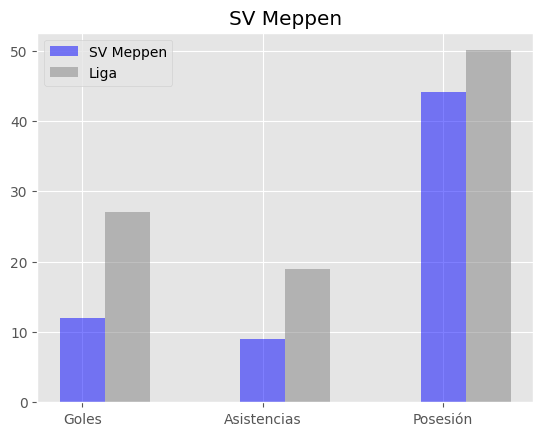

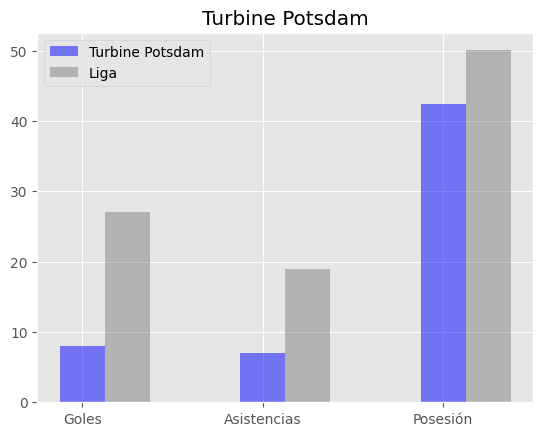

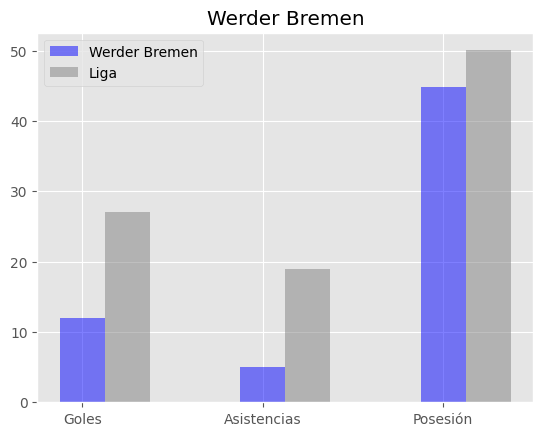

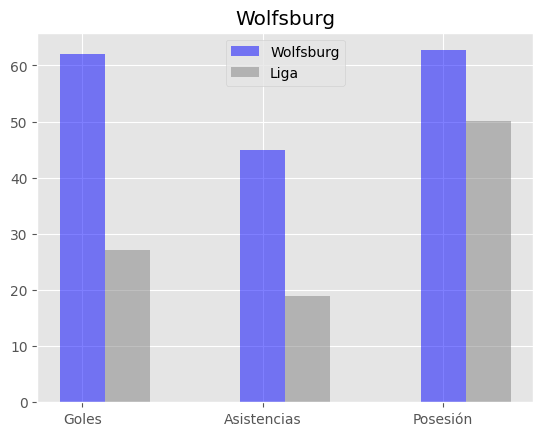

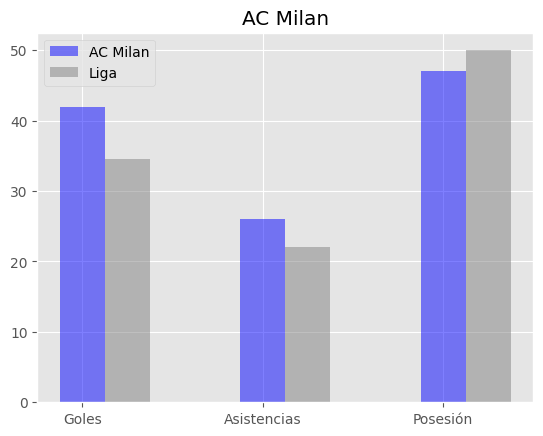

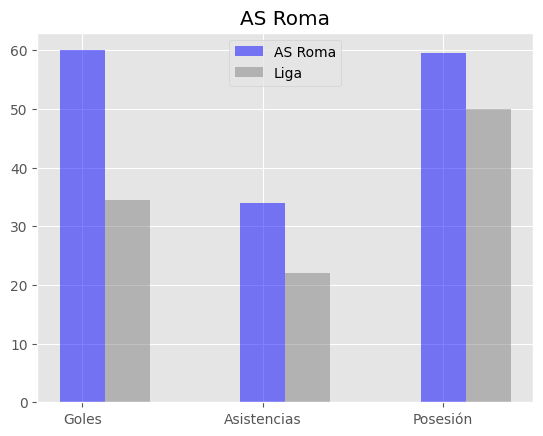

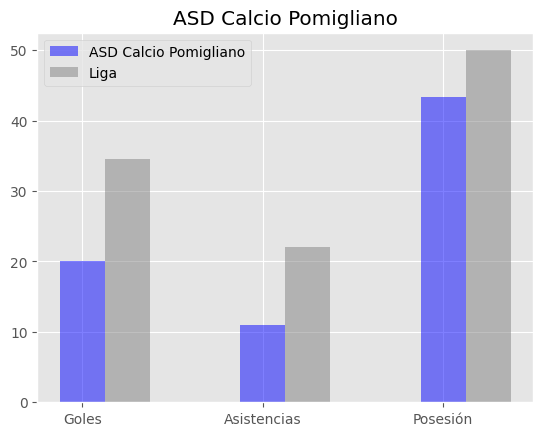

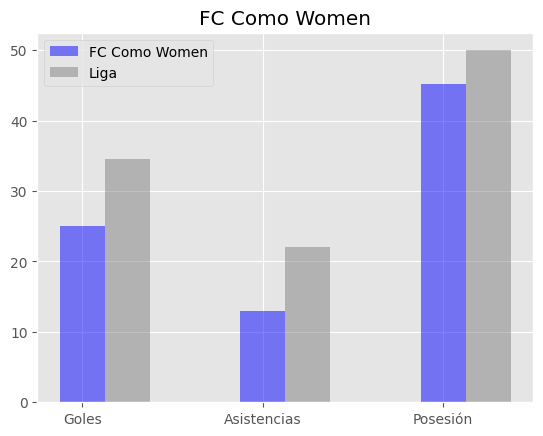

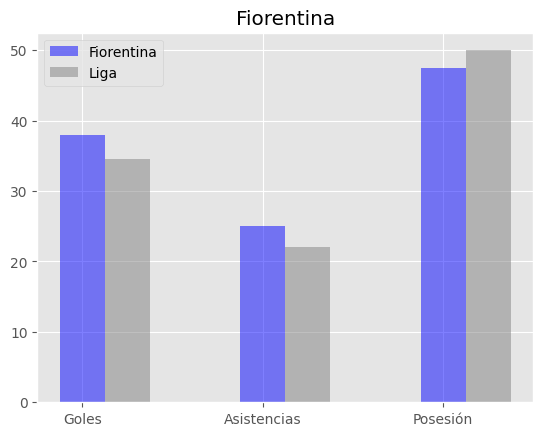

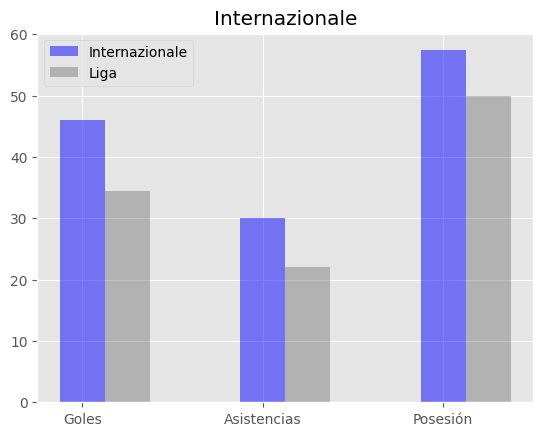

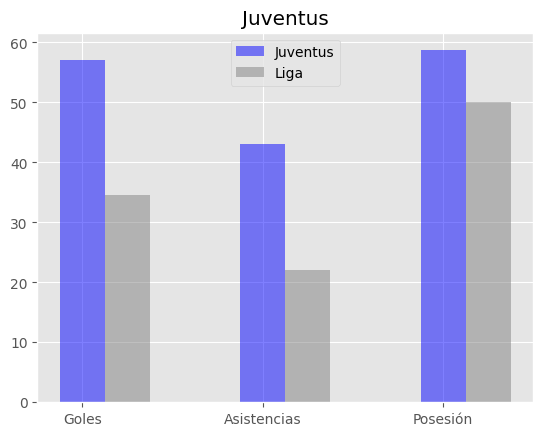

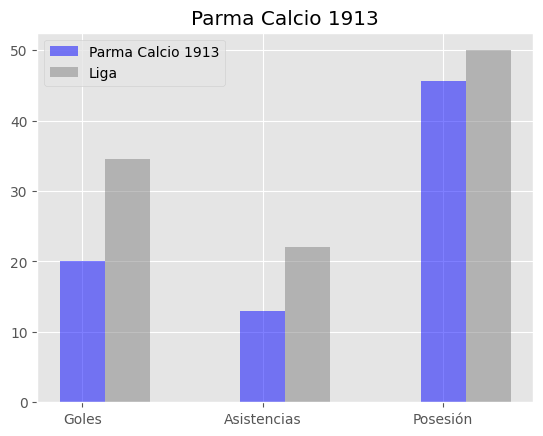

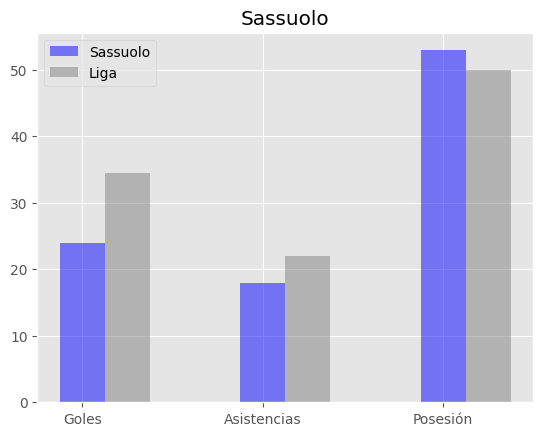

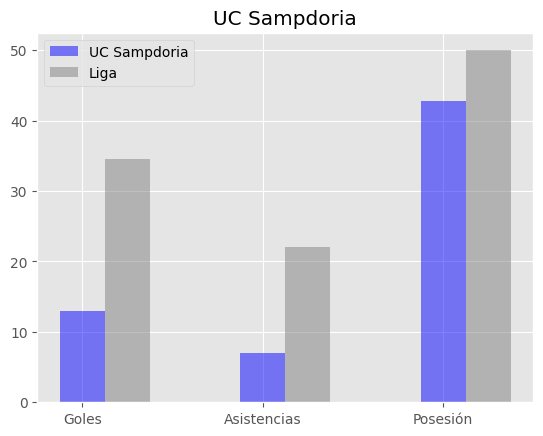

In [30]:
# Gráficamos una comparación entre los stats del equipo frente al promedio de la liga
for team in team_attstats.index:
  team_attack = team_attstats.loc[team, ['gls_x','ast_x','poss_x']]
  team_attack2 = team_attstats.loc[team, ['gls_y','ast_y','poss_y']]
  plt.figure()
  pos = list(range(len(team_attack)))
  plt.bar(pos, team_attack, width=0.25, alpha=0.5, color='blue', label=f'{team}')
  plt.bar([p + 0.25 for p in pos], team_attack2, width=0.25, alpha=0.5, color='gray', label='Liga')
  plt.xticks(range(3), ['Goles','Asistencias','Posesión'])
  plt.legend()
  plt.title(f'{team}')

# Jugadoras

In [33]:
jugadores = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/players_1.csv").loc[:, ["Player_id", "Player", "Squad_id", "Nation", "Pos", "Age", "Born", "MP", "Min", "Gls", "Ast", "PK", "CrdY", "CrdR", "SoT", "Passes_Cmp", "Tkl", "Blocks", "Fls", "Fld", "Off", "PKcon", "Recov"]]
jugadores.head()

,Player_id,Player,Squad_id,Nation,Pos,Age,Born,MP,Min,Gls,...,CrdR,SoT,Passes_Cmp,Tkl,Blocks,Fls,Fld,Off,PKcon,Recov
0,46f75f0c,Teresa Abilleira,54582b93,es ESP,MF,23.0,2000,20,1147,3,...,0,8.0,701.0,35.0,13.0,20.0,19.0,0.0,0.0,98.0
1,72c566fe,Jessica Aby,aa11fb42,ci CIV,"MF,FW",24.0,1998,17,548,1,...,1,5.0,113.0,14.0,3.0,32.0,14.0,2.0,0.0,34.0
2,67a39a11,Charity Adule,e9fecaf2,NaN,"FW,MF",29.0,1993,9,171,0,...,0,0.0,20.0,5.0,4.0,1.0,4.0,1.0,0.0,12.0
3,a097ef45,Júlia Aguado,0f4738a8,NaN,"FW,MF",22.0,2000,15,119,3,...,0,4.0,25.0,1.0,1.0,4.0,1.0,4.0,0.0,7.0
4,150b2d3b,Yolanda Aguirre,215d9026,es ESP,GK,24.0,1998,5,450,0,...,0,0.0,94.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0


Relacionamos el dataset con el de "partidos" para obtener la liga correspondiente de cada jugadora.

In [34]:
jugadores = matches[["Home_id", "League_name"]].merge(jugadores, left_on="Home_id",right_on= "Squad_id")
jugadores.head()

,Home_id,League_name,Player_id,Player,Squad_id,Nation,Pos,Age,Born,MP,...,CrdR,SoT,Passes_Cmp,Tkl,Blocks,Fls,Fld,Off,PKcon,Recov
0,15f49df1,Liga-F,f3d165f5,Aitana Bonmatí,15f49df1,es ESP,MF,25.0,1998,20,...,0,27.0,877.0,20.0,8.0,6.0,13.0,8.0,0.0,96.0
1,15f49df1,Liga-F,5056c581,Lucy Bronze,15f49df1,eng ENG,DF,31.0,1991,20,...,0,9.0,973.0,46.0,14.0,17.0,14.0,5.0,0.0,106.0
2,15f49df1,Liga-F,59da315a,Mariona Caldentey,15f49df1,es ESP,"FW,MF",27.0,1996,15,...,0,14.0,743.0,15.0,7.0,3.0,16.0,4.0,0.0,71.0
3,15f49df1,Liga-F,607dd291,Alba Caño,15f49df1,NaN,MF,19.0,2003,1,...,0,1.0,28.0,2.0,0.0,3.0,0.0,0.0,0.0,4.0
4,15f49df1,Liga-F,1efbd058,Laia Codina,15f49df1,es ESP,DF,23.0,2000,11,...,0,0.0,520.0,6.0,8.0,6.0,3.0,0.0,0.0,52.0


In [35]:
# Obtenemos un dataframe solo con jugadoras que no sean porteras
jugadores_de_campo = jugadores[jugadores["Pos"] != "GK"]

In [39]:
def quedarse_posiciones(posiciones):
  """Obtenemos la posición principal
  de cada jugadora para una vista mas
  general"""
  if "DF" in posiciones:
      return "Defensa"
  elif "MF" in posiciones:
    return "Centrocampista"
  elif "FW" in posiciones:
    return "Delantero"

jugadores_de_campo["Pos"] = jugadores_de_campo["Pos"].apply(quedarse_posiciones)

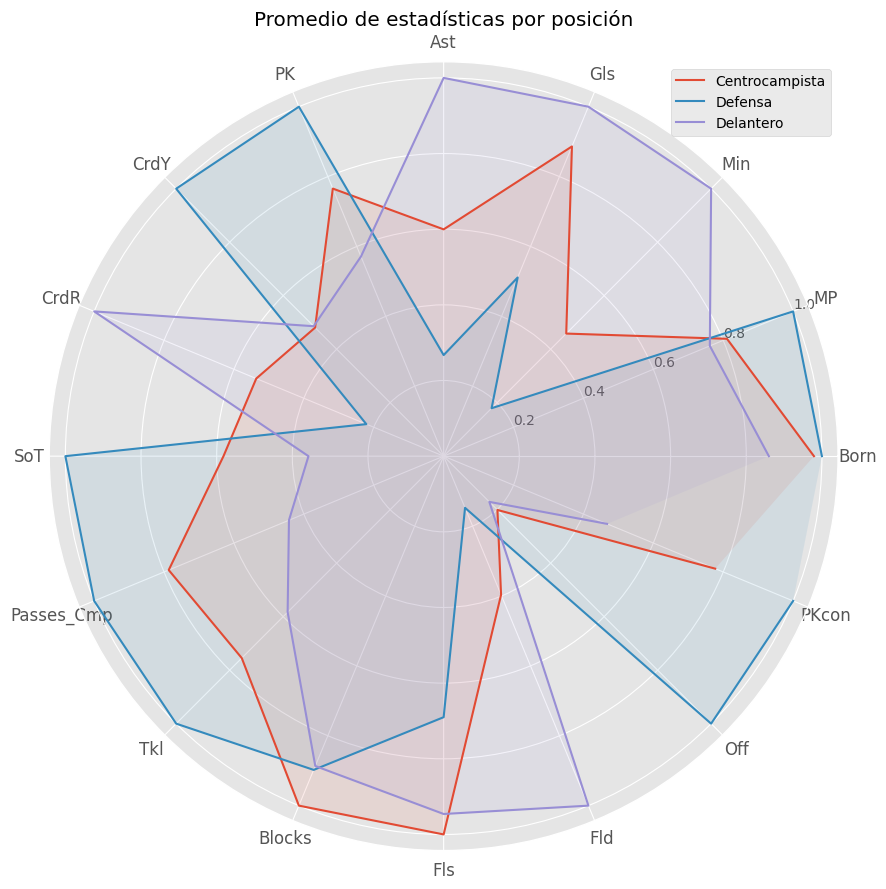

In [41]:
# Crear un diccionario vacío para almacenar los datos de cada posición
posiciones = {}

# Iterar sobre cada posición y almacenar los datos en el diccionario
for posicion in jugadores_de_campo.Pos.unique():
    df_posicion = jugadores_de_campo[jugadores_de_campo["Pos"] == posicion].drop(columns=["Home_id", "League_name", 
                                                                                          "Player_id", "Player", "Squad_id", 
                                                                                          "Nation", "Pos", "Age", "Born"])
    posiciones[posicion] = df_posicion.mean()

# Convertir el diccionario en un DataFrame
df_posiciones = pd.DataFrame(posiciones).T

nombres_stats = list(df_posiciones.columns)

# Calcular el valor máximo de cada columna para ajustar el eje de cada radar
max_values = df_posiciones.max()

# Crear la figura de matplotlib con subplots
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize = (9,9))

# Crear un radar para cada posición y superponerlos en la misma figura
for i, row in df_posiciones.iterrows():
    theta = [2 * i * 3.14159 / len(row) for i in range(len(row))]
    plt.xticks(theta, nombres_stats)
    ax.plot(theta, row / max_values, label=i)

    ax.fill(theta, row / max_values, alpha=0.1)
    ax.set_xticklabels(jugadores_de_campo.columns[8:-1], fontsize=12)


# Configurar el título y la leyenda de la figura
ax.set_title("Promedio de estadísticas por posición")
ax.legend()
plt.tight_layout()
plt.show()

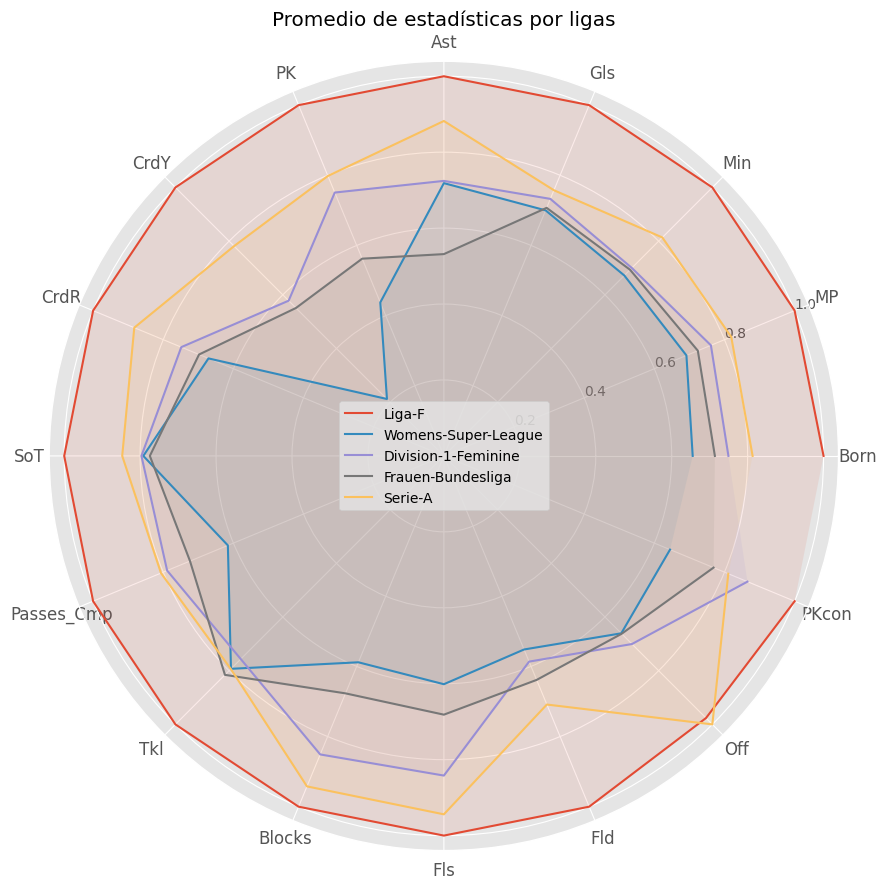

In [42]:
ligas = {}

# Iterar sobre cada posición y almacenar los datos en el diccionario
for liga in jugadores_de_campo.League_name.unique():
    df_ligas = jugadores_de_campo[jugadores_de_campo["League_name"] == liga].drop(columns=["League_name", "Player_id", "Player", "Squad_id", "Nation", "Pos", "Age", "Born"])
    ligas[liga] = df_ligas.mean()

# Convertir el diccionario en un DataFrame
df_ligas = pd.DataFrame(ligas).T

nombres_stats = list(df_ligas.columns)

# Calcular el valor máximo de cada columna para ajustar el eje de cada radar
max_values = df_ligas.max()

# Crear la figura de matplotlib con subplots
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize = (9,9))

# Crear un radar para cada posición y superponerlos en la misma figura
for i, row in df_ligas.iterrows():
    theta = [2 * i * 3.14159 / len(row) for i in range(len(row))]
    plt.xticks(theta, nombres_stats)
    ax.plot(theta, row / max_values, label=i)

    ax.fill(theta, row / max_values, alpha=0.1)
    ax.set_xticklabels(jugadores_de_campo.columns[8:-1], fontsize=12)


# Configurar el título y la leyenda de la figura
ax.set_title("Promedio de estadísticas por ligas")
ax.legend()
plt.tight_layout()
plt.show()

### Histograma de la edad por equipo

In [45]:
# Hacemos un dataframe solo con el id del equipo, liga y nombre
equipo = teams.loc[:, ["Squad_id", "Squad"]]
equipo_liga = matches.loc[:, ["Home_id", "League_name"]].drop_duplicates()
equipo_liga.columns = ["Squad_id", "League_name"]
todo_junto = equipo.merge(equipo_liga, on = "Squad_id")
todo_junto.head()

,Squad_id,Squad,League_name
0,aa11fb42,Alavés,Liga-F
1,e9fecaf2,Alhama,Liga-F
2,94929c05,Athletic Club,Liga-F
3,b56c2667,Atlético Madrid,Liga-F
4,15f49df1,Barcelona,Liga-F


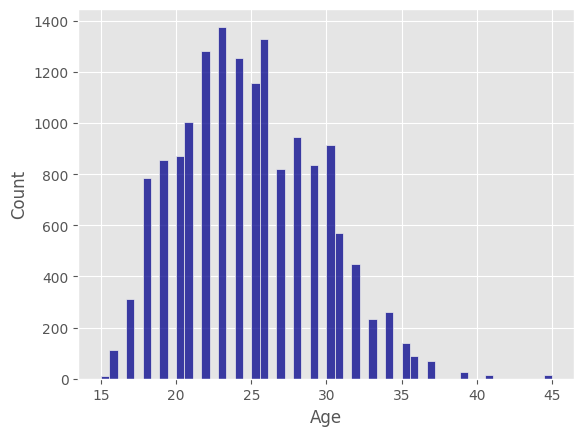

In [56]:
sns.histplot(data = jugadores, x = "Age", color='darkblue')
plt.show()

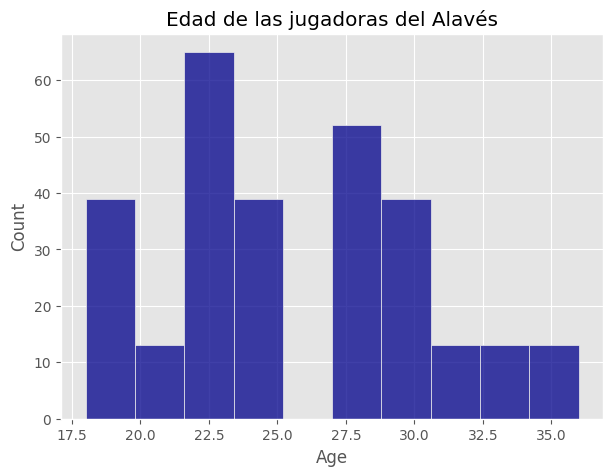

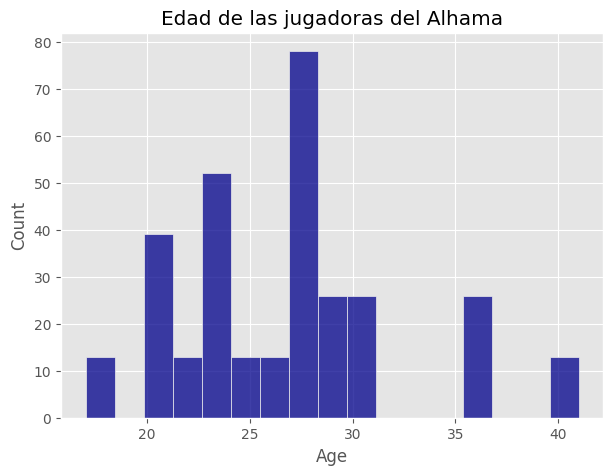

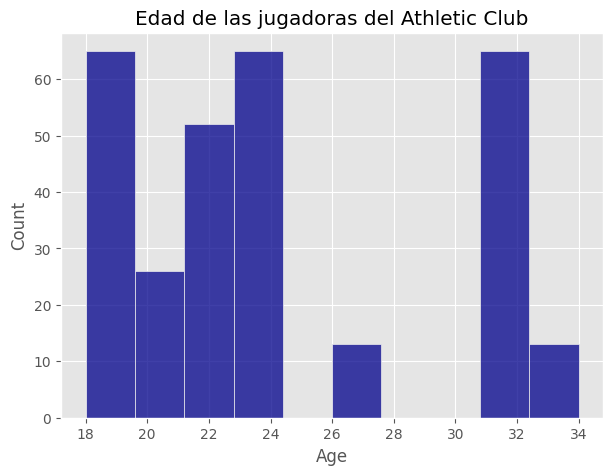

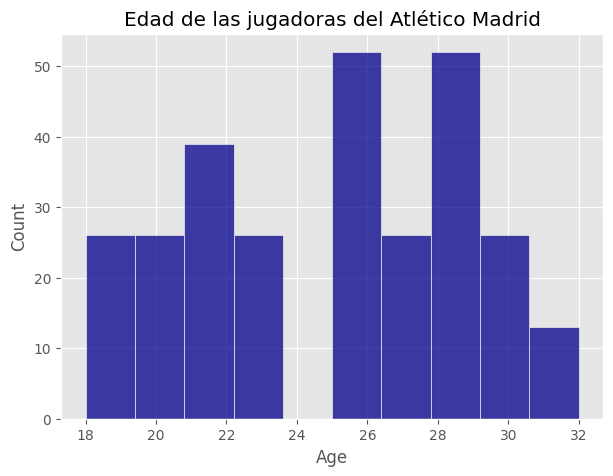

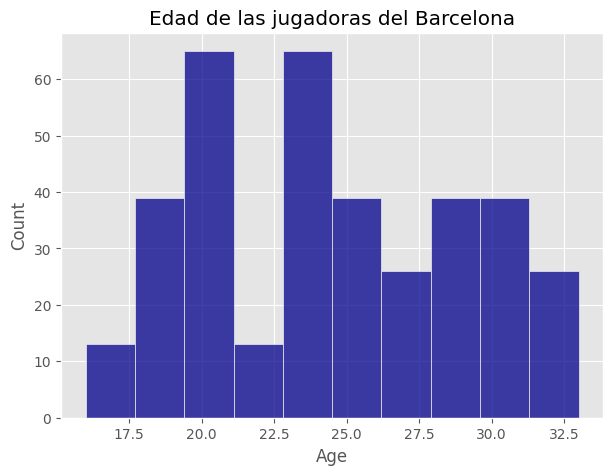

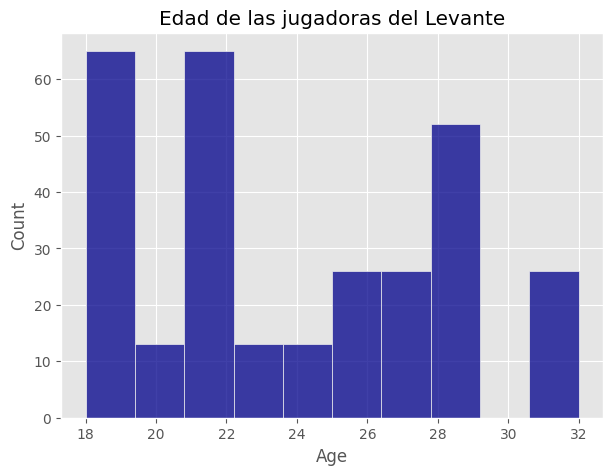

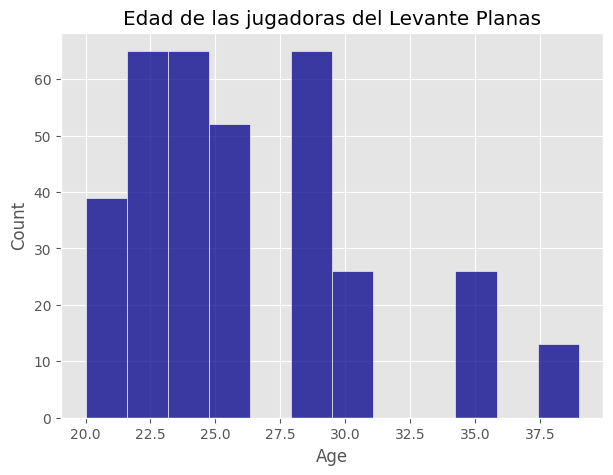

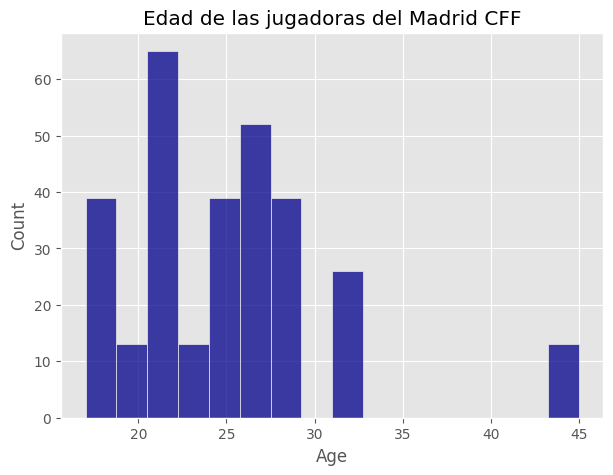

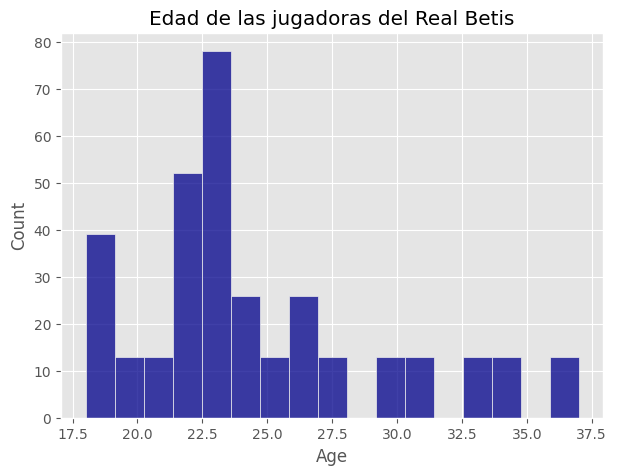

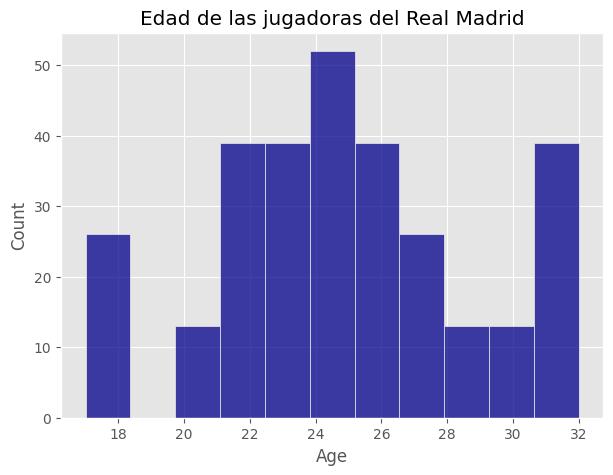

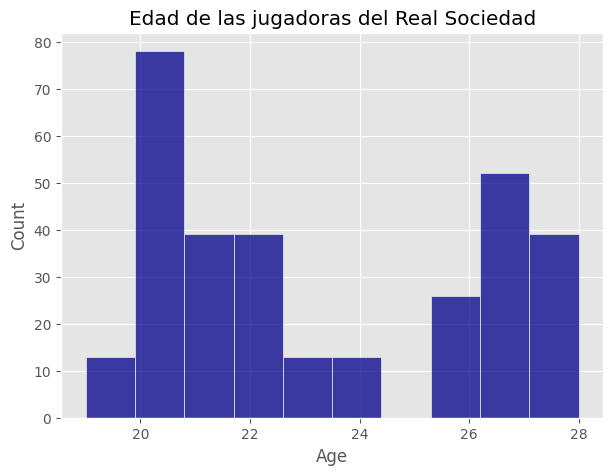

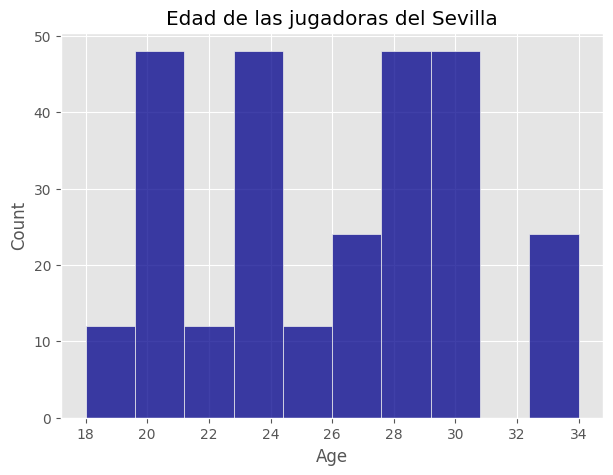

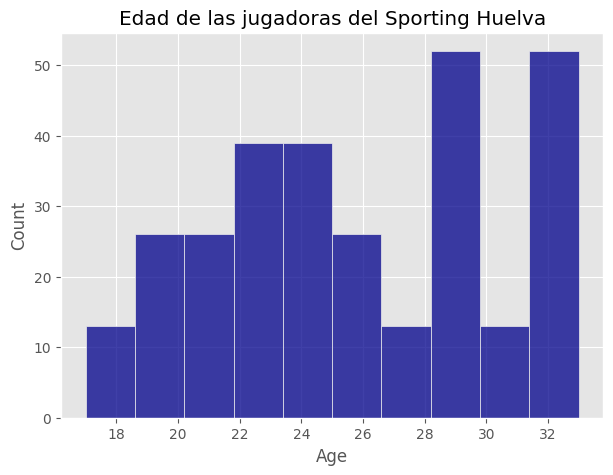

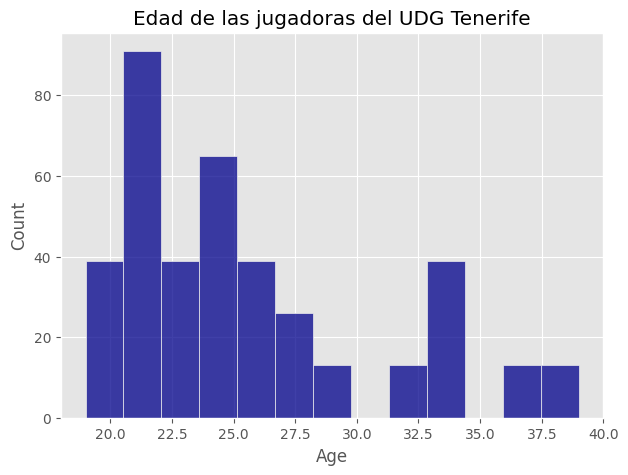

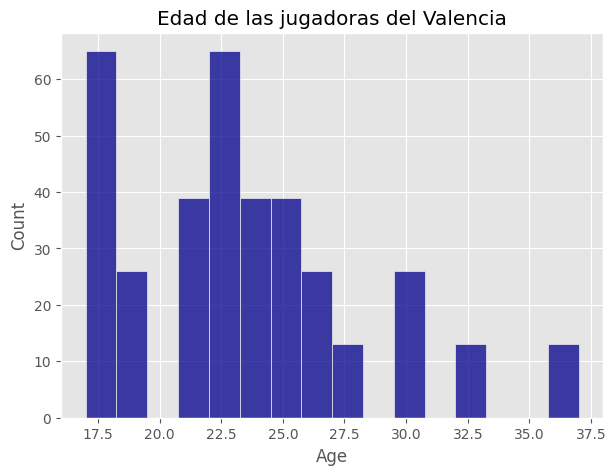

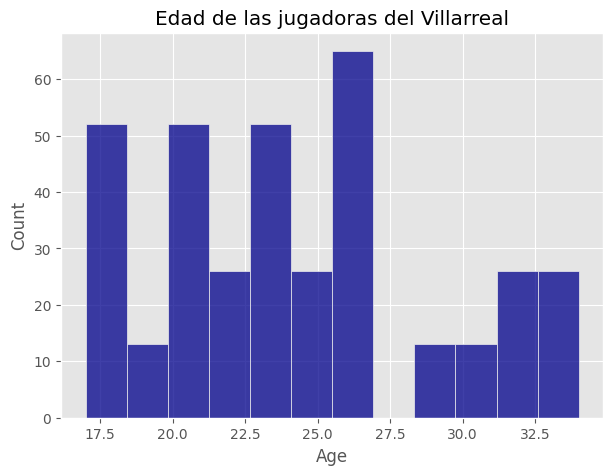

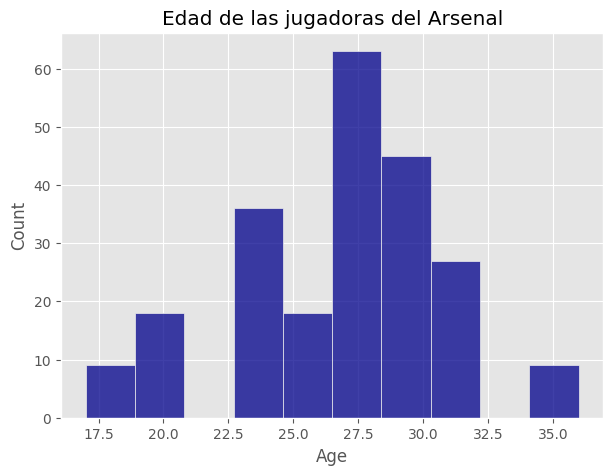

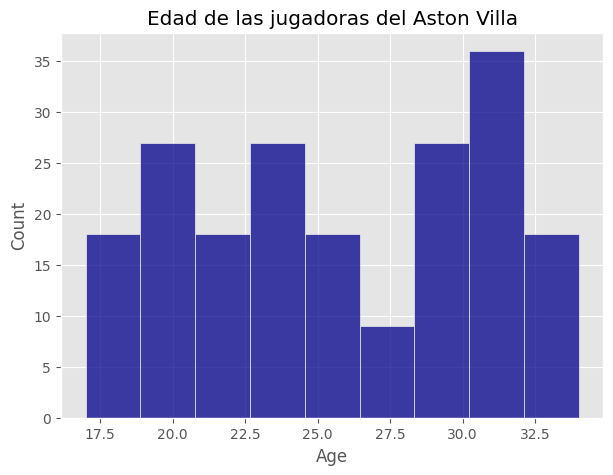

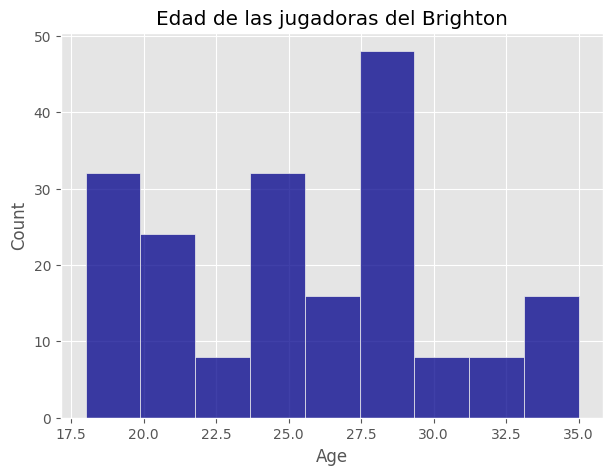

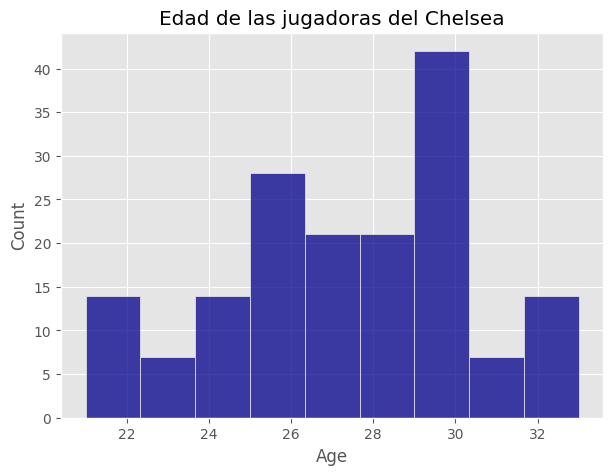

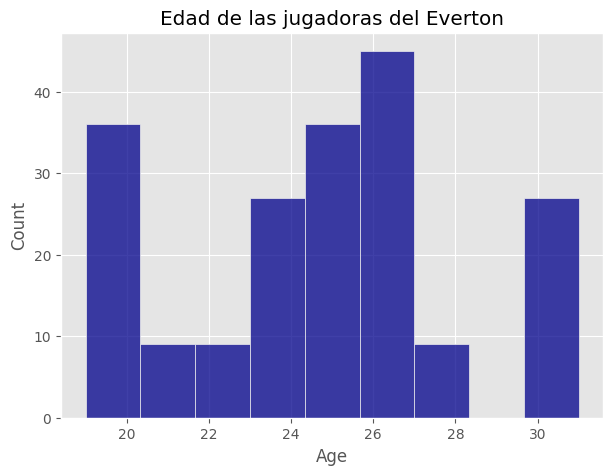

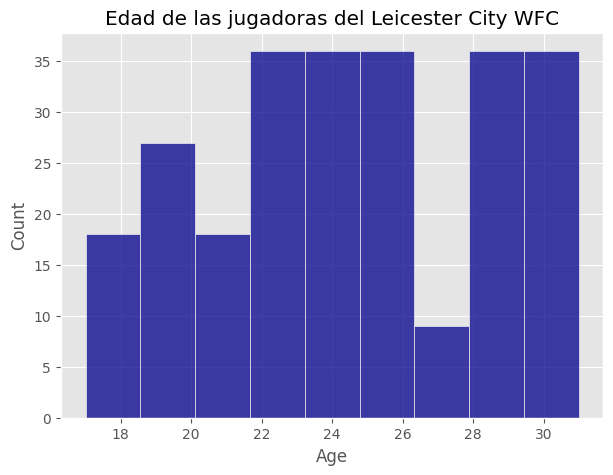

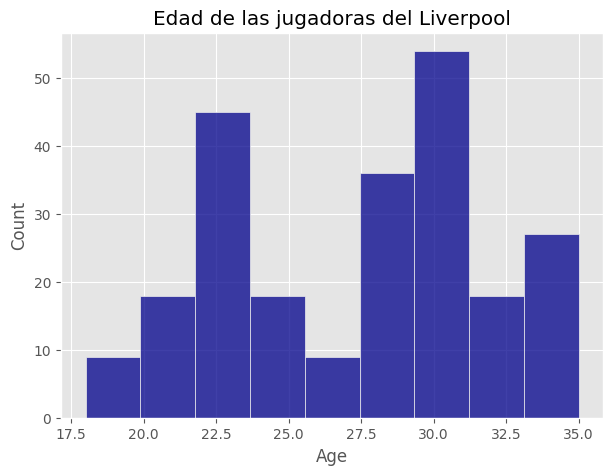

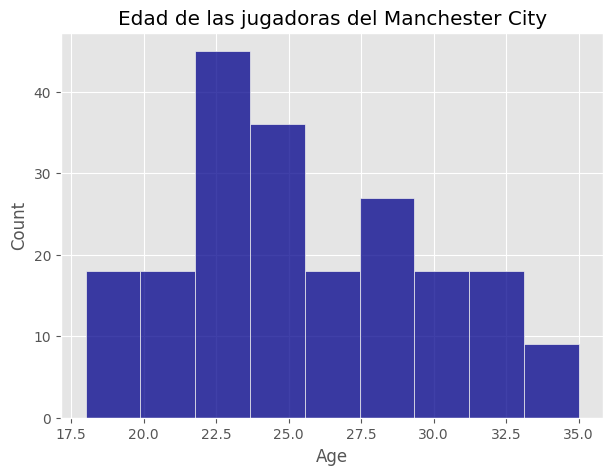

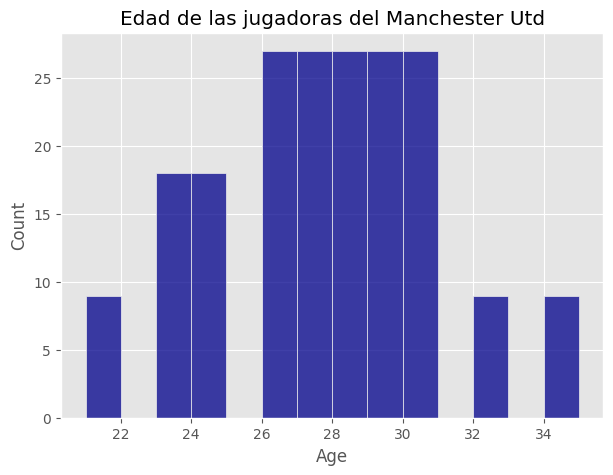

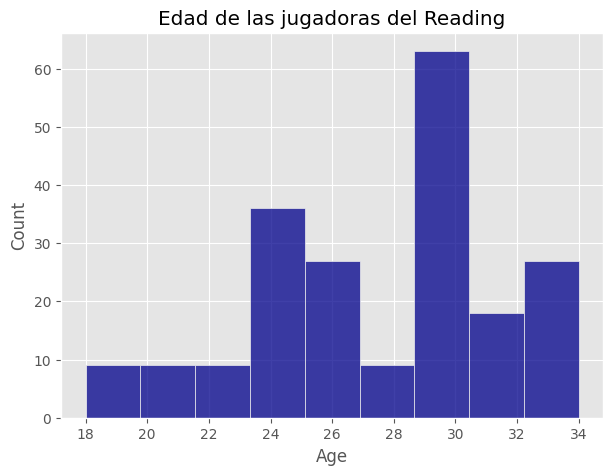

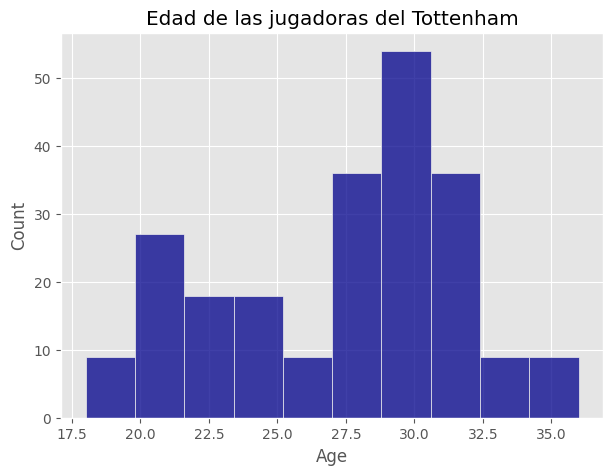

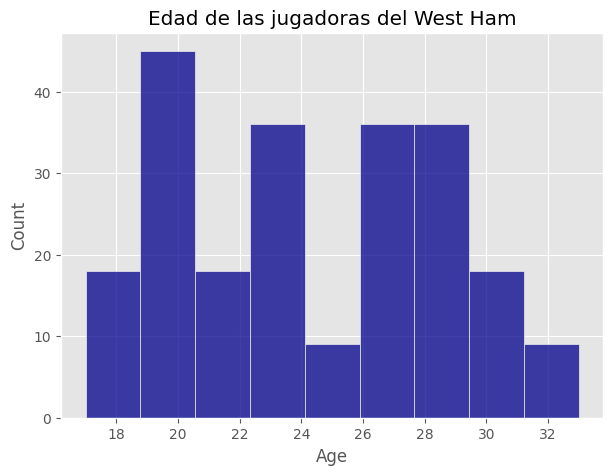

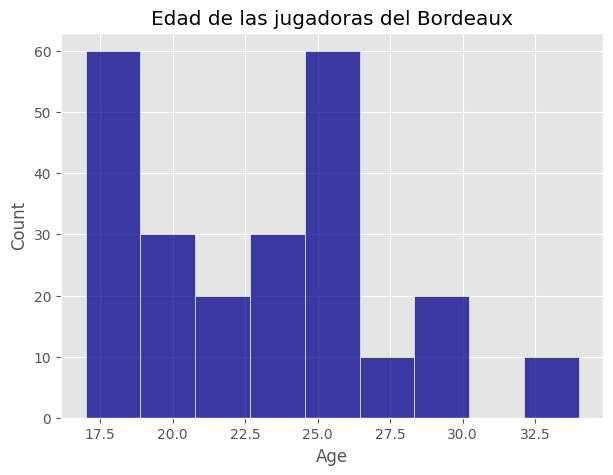

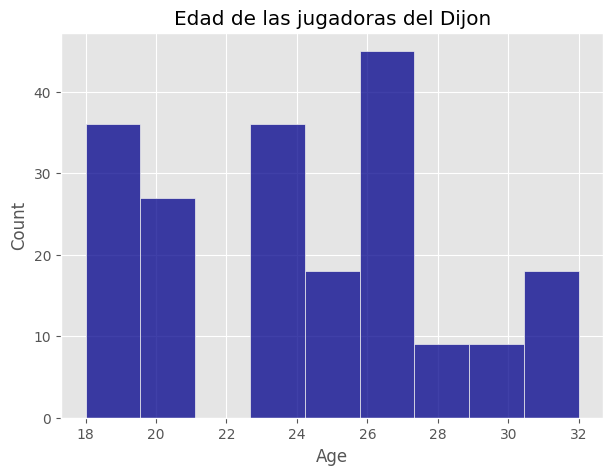

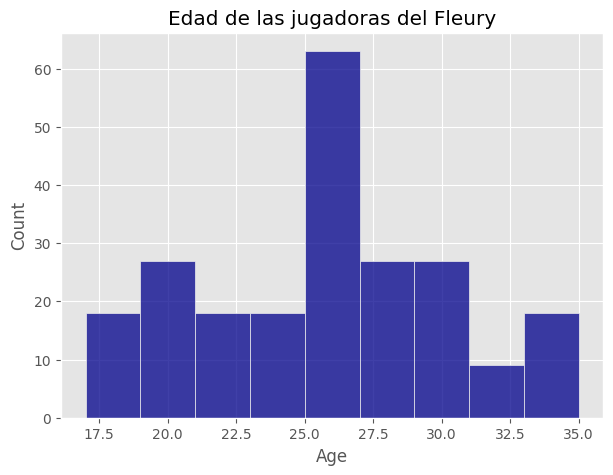

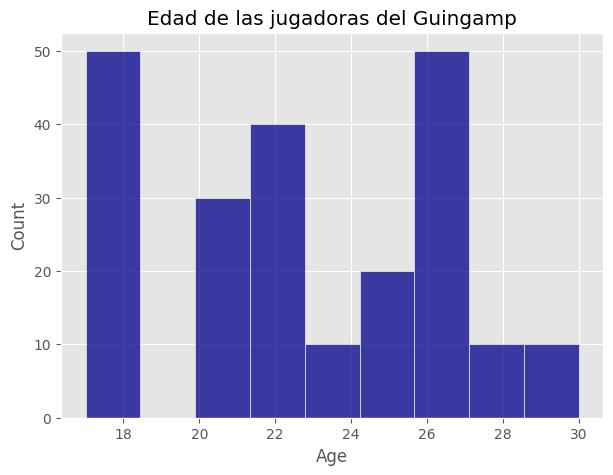

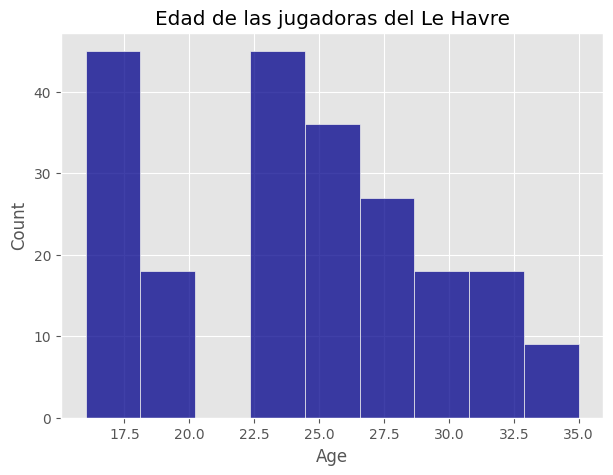

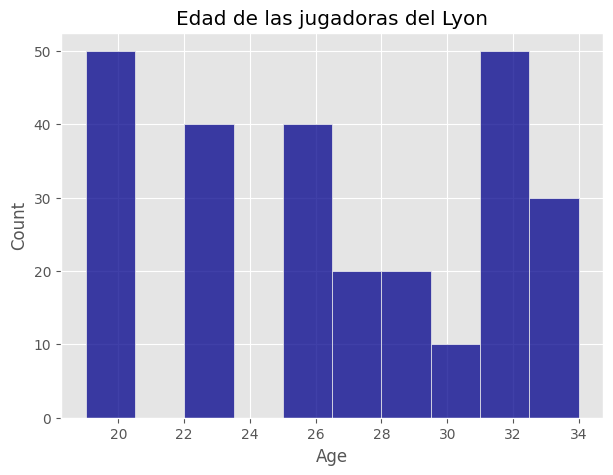

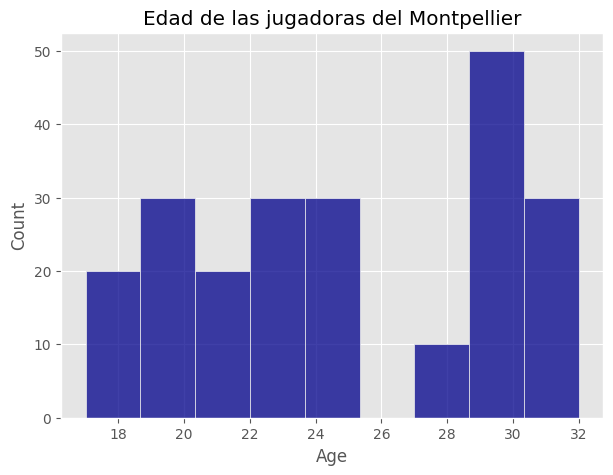

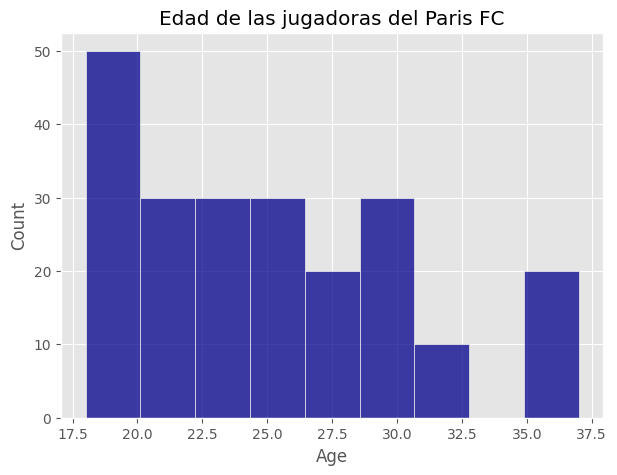

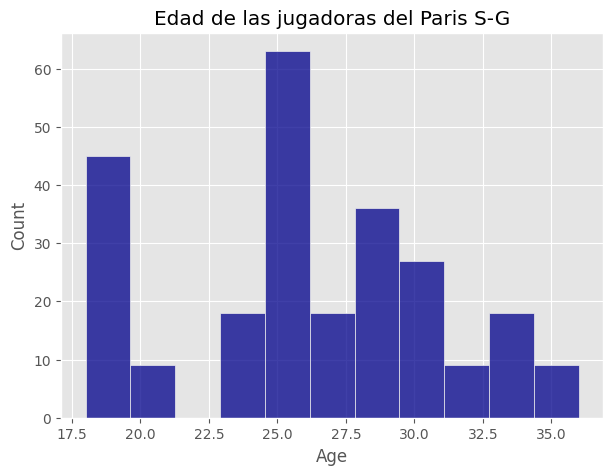

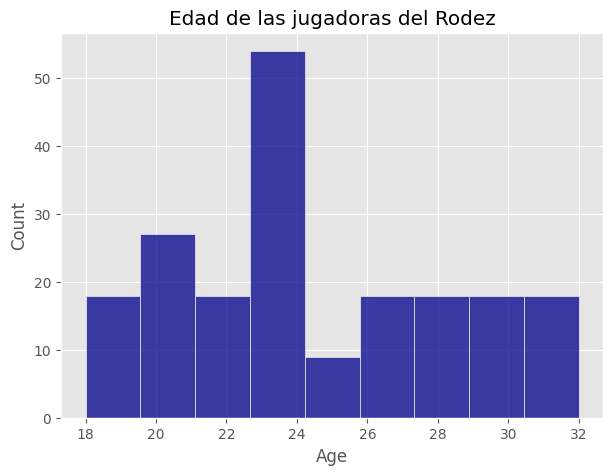

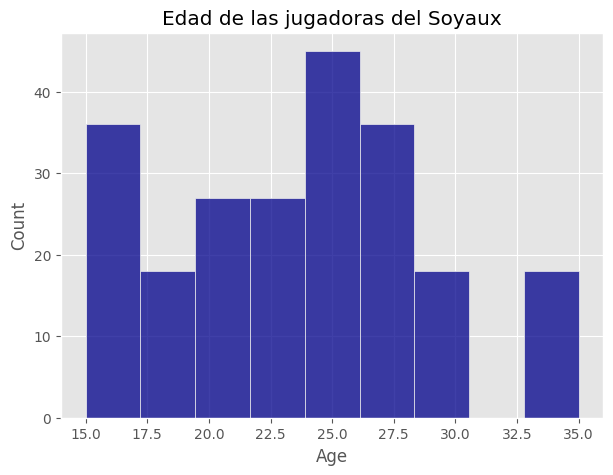

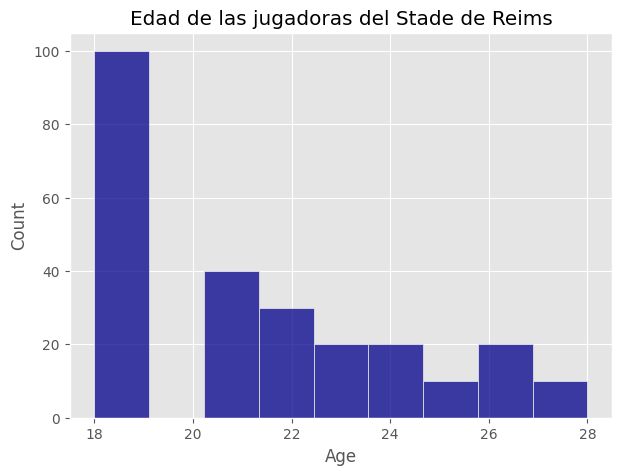

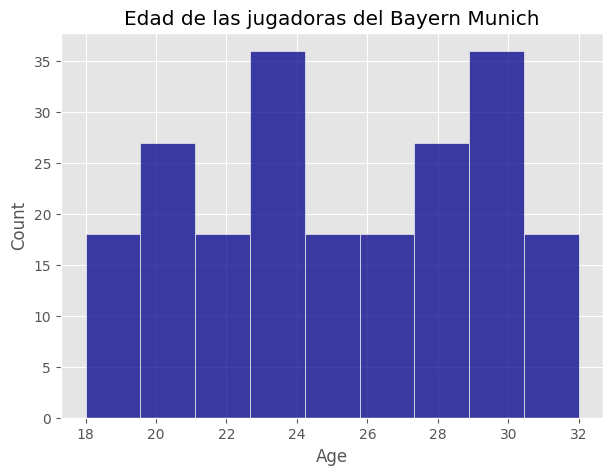

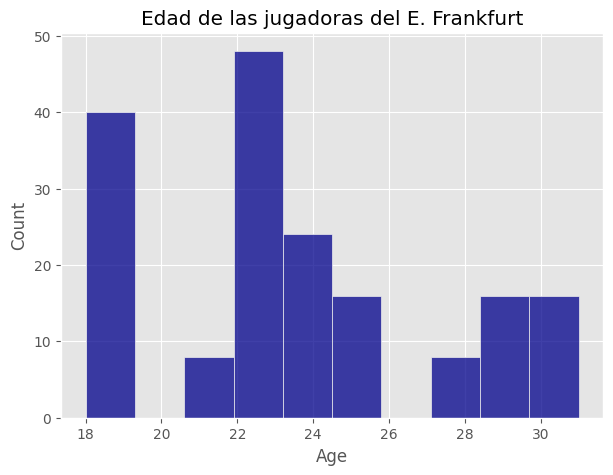

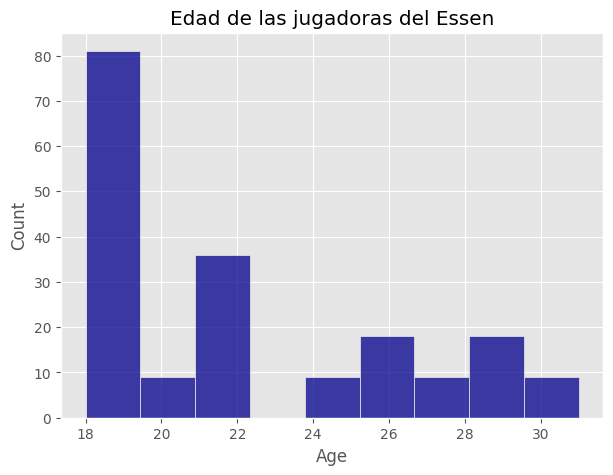

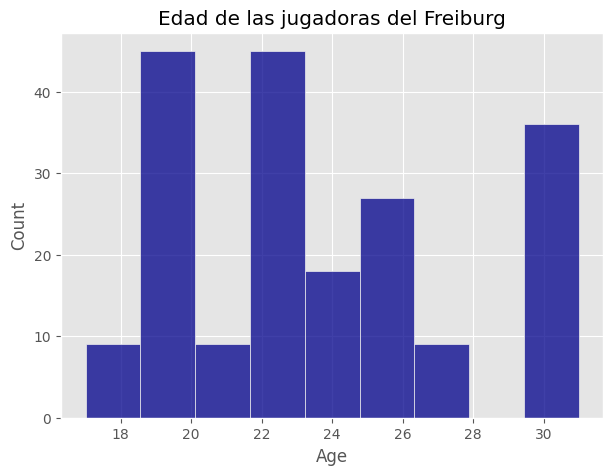

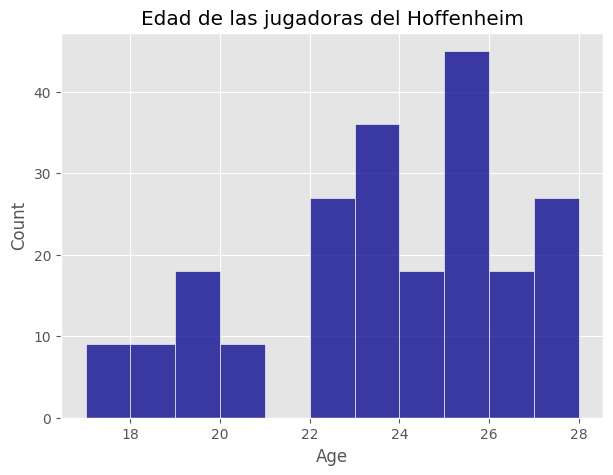

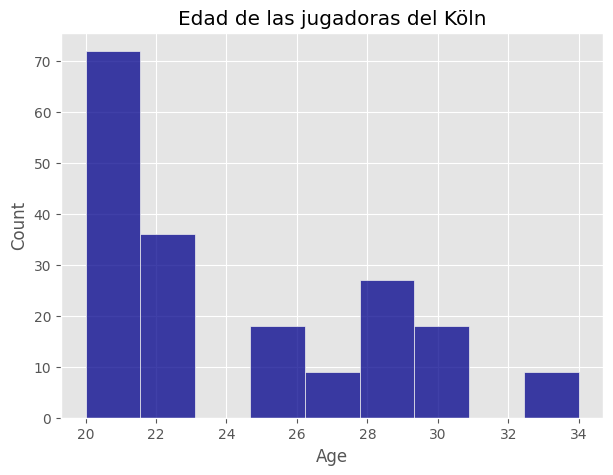

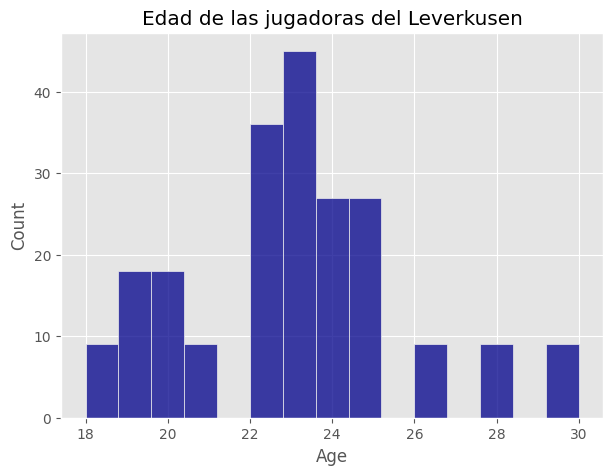

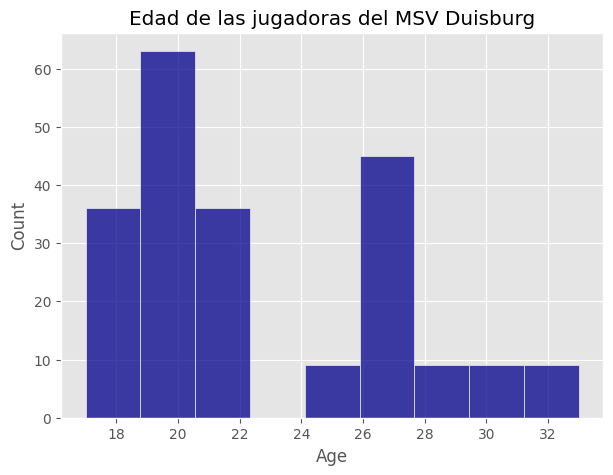

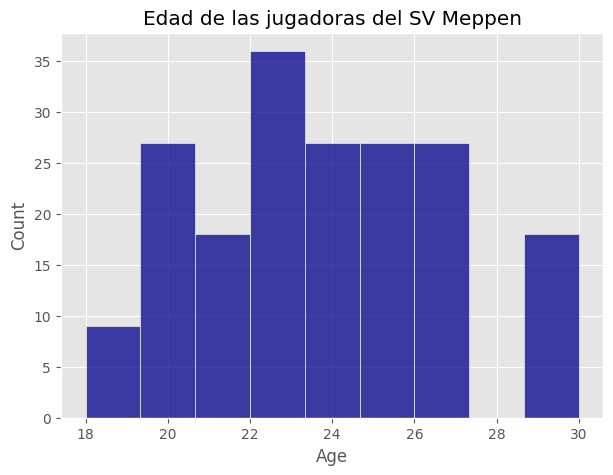

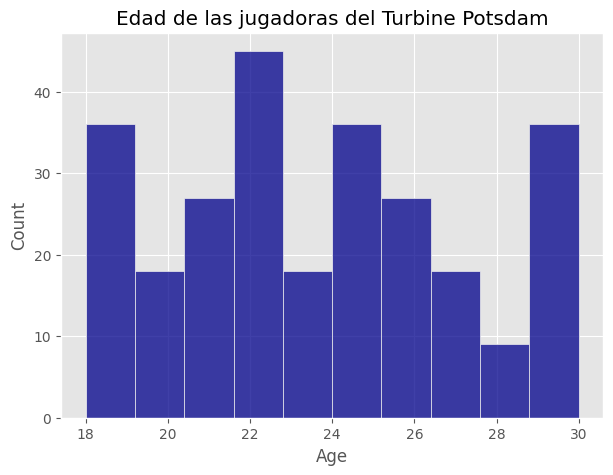

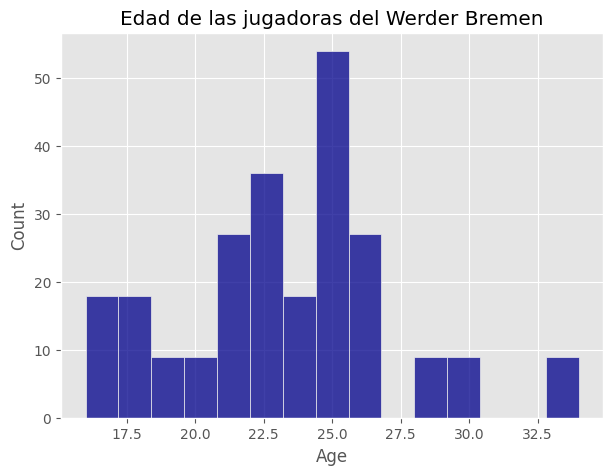

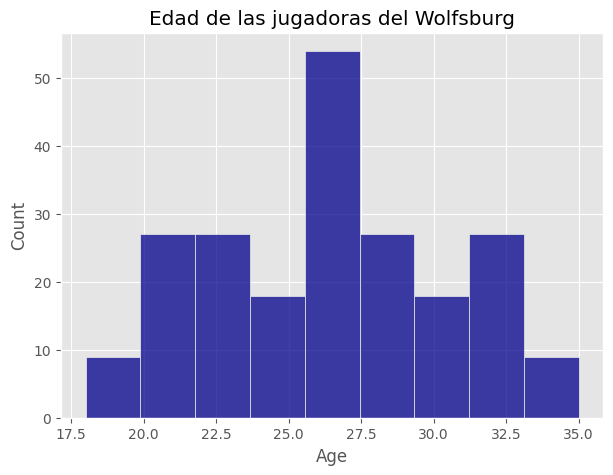

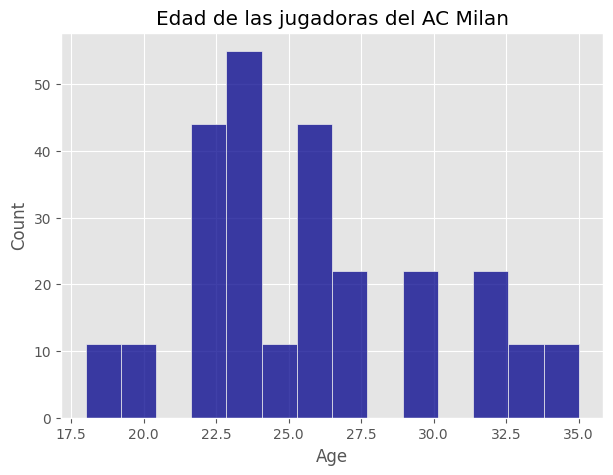

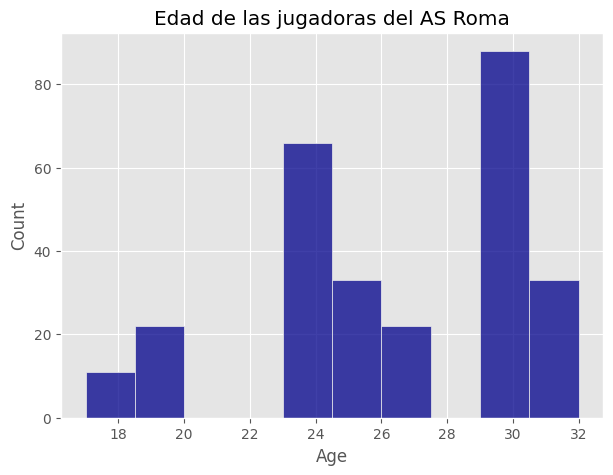

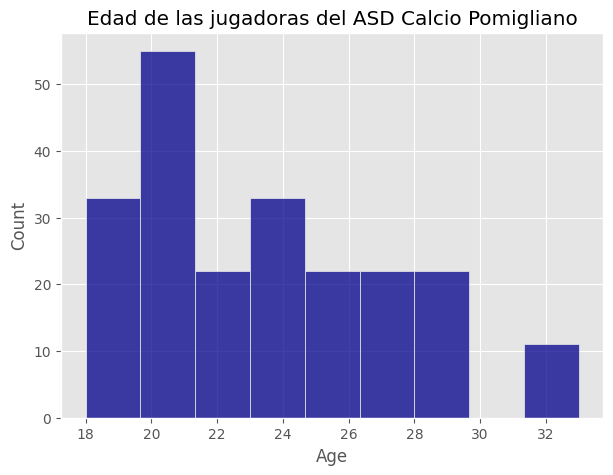

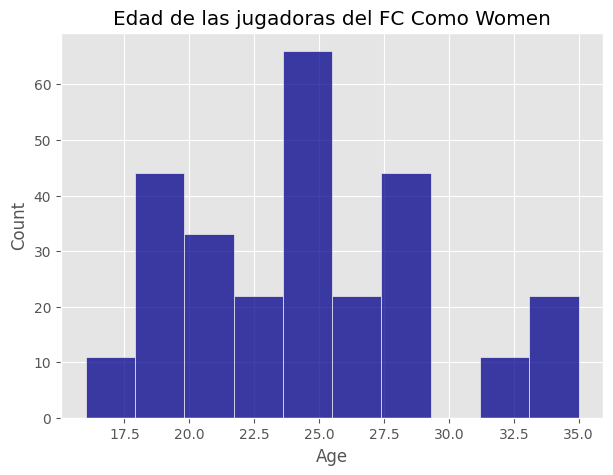

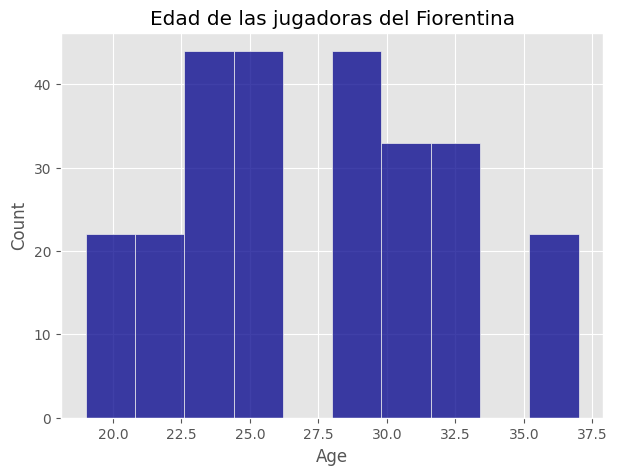

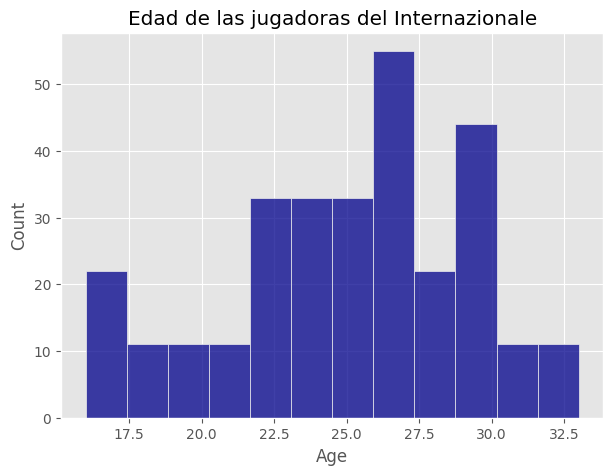

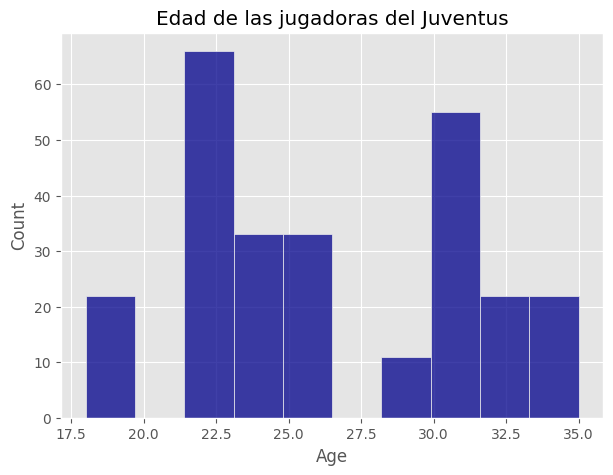

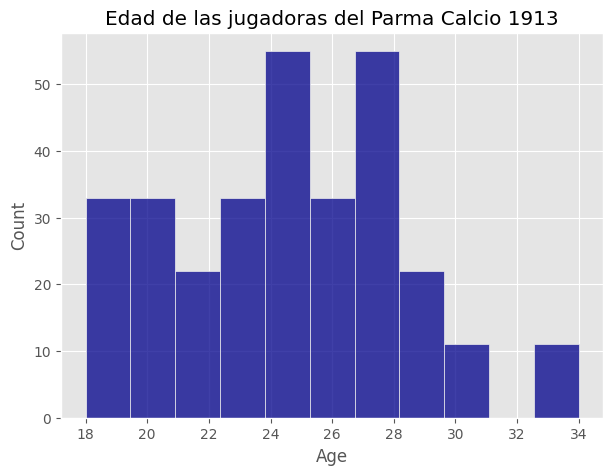

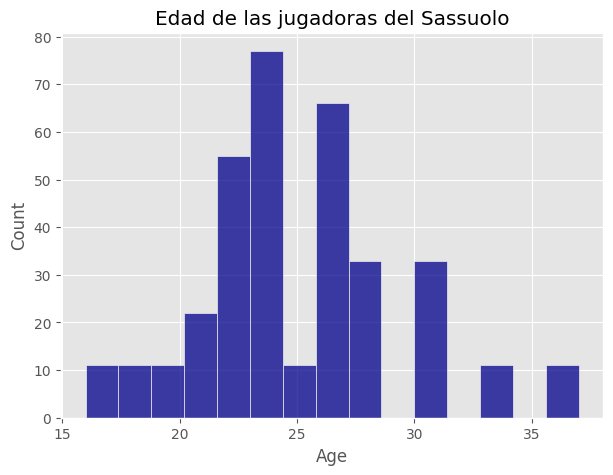

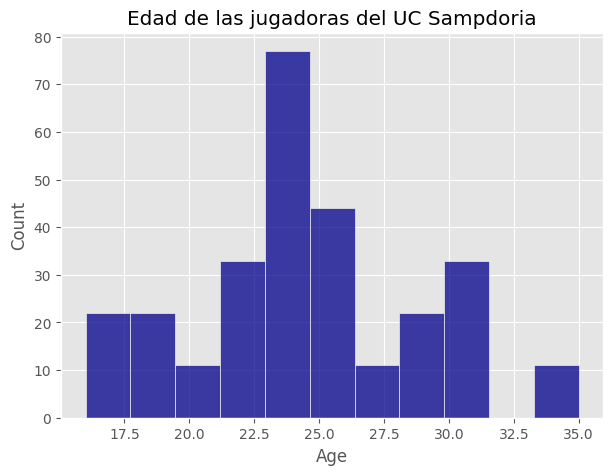

In [57]:
for x in todo_junto["Squad_id"]:
    fig, ax = plt.subplots( figsize = (7,5))
    sns.histplot(data = jugadores[jugadores["Squad_id"] == x], x = "Age", color='darkblue')
    plt.title("Edad de las jugadoras del " + todo_junto[todo_junto["Squad_id"] == x]["Squad"].values[0])
    plt.show()